# functions

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from multiprocessing import Pool, cpu_count
import tqdm
import random
from pathlib import Path
import pandas as pd

In [2]:
def caf(tt,k1,k2,k3,k4,xxx0):
    y = ((-np.exp(-(k3+k2)*tt)+np.exp(-k1*tt))*k1)/(k3+k2-k1)
    return y

def xxx(tt,k1,k2,k3,k4,xxx0):
    y = (np.exp(-(k1+k4)*tt)*(-np.exp(k4*tt)*k2*k1*(k3+k2-k4)+np.exp((-k3-k2+k1+k4)*tt)*k2*k1*(k1-k4)-np.exp(k1*tt)*(-k3-k2+k1)*((k3-k4)*(k1-k4)*xxx0+k2*(k1+k1*xxx0-k4*xxx0))))/((k3+k2-k1)*(k3+k2-k4)*(k1-k4))
    return y

In [3]:
def fast_avg_matrix(array):
    return np.mean(array.reshape(2,-1,array.shape[1],order='F'),axis=0)

def load_data(donors):
    '''
    Loads (normalized by machine standard) raw data from a list of donors.
    Returns DataFrames in a dictionary.
    '''
    
    data = {}
    for donor in donors:
        df = pd.read_csv(f'targeted/{donor}.csv')
        tmp = pd.DataFrame(index=range(len(df['time'].values[0::2])),dtype=float,columns=['time','Caffeine','Paraxanthine','Theobromine','Theophylline'])
        tmp.loc[:,:] = fast_avg_matrix(df.values)
        data[donor] = tmp
    
    return data

def optimization_problem_robust_loss_production(_input):
    '''
    Uses _input list of donor_name, sampled p0, and bounds (lb, ub). Calls curve_fit() and writes out the fitted parameters.
    '''
    
    # the loss parameters alpha and scale are initially estimated as 1
    global alpha, scale, loss
    alpha, scale = 1, 1
    # reading the input
    donor, p0, lb, ub, metabolite = _input
    # doing data preprocessing
    x_values, y_values, s_values = preprocessing_data(data,donor,metabolite)

    # in rare cases initial parameters can lead to NaNs which can create errors. This is excepted here.
    try:
        para, var = curve_fit(f         = fit_with_sv,
                              xdata     = x_values,
                              ydata     = y_values,
                              sigma     = s_values,
                              absolute_sigma= True,
                              p0        = p0,
                              bounds    = (lb.astype('float64') ,ub.astype('float64')),
                              method    = 'trf',
                              max_nfev  = 1000,
                              loss      = max_cauchy_loss,
                              tr_solver = 'exact')
        observed = y_values
        expected = fit_with_sv(x_values,*para)
        loss = np.sum(max_cauchy_loss((np.abs(observed-expected)/s_values)**2)[0])
        return [donor,metabolite, list(para), float(loss)]
    except (ValueError,RuntimeError) as e:
        return '#Error'
    
def optimization_problem_robust_loss_debug(_input):
    '''
    Uses _input list of donor_name, sampled p0, and bounds (lb, ub). Calls curve_fit() and writes out the fitted parameters.
    '''
    
    # the loss parameters alpha and scale are initially estimated as 1
    global alpha, scale, loss
    alpha, scale = 1, 1
    # reading the input
    donor, p0, lb, ub, metabolite = _input
    # doing data preprocessing
    x_values, y_values, s_values = preprocessing_data(data,donor,metabolite)
    # in rare cases initial parameters can lead to NaNs which can create errors. This is excepted here.
#     try:
    para, var = curve_fit(f         = fit_with_sv,
                          xdata     = x_values,
                          ydata     = y_values,
                          sigma     = s_values,
                          absolute_sigma= True,
                          p0        = p0,
                          bounds    = (lb.astype('float64') ,ub.astype('float64')),
                          method    = 'trf',
                          max_nfev  = 1000,
                          loss      = max_cauchy_loss,
                          tr_solver = 'exact')
    observed = y_values
    expected = fit_with_sv(x_values,*para)
    loss = np.sum(max_cauchy_loss((np.abs(observed-expected)/s_values)**2)[0])
    return [donor,metabolite, list(para), float(loss)]
#     except (ValueError,RuntimeError) as e:
#         return '#Error'

def preprocessing_data(data,donor,metabolite):
    '''
    Takes raw data dictionary and donor name.
    Parses x_values and y_values.
    Transforms y_values by calibration curve.
    Assigns 10**8 sigma values (= weights) to all 0s because they are below LOQ and thus regarded as NaNs.
    Returns x_values, sigma, y_values as float64 np.arrays.
    '''
    
    x_values = data[donor]['time'].copy()
    y_values = np.array(data[donor].loc[:,['Caffeine','Paraxanthine','Theobromine','Theophylline']].copy())
    y_values = y_values.flatten()
    
    # apply calibration curve
    calibration_k = np.array([np.ones(len(x_values))*1.520,np.ones(len(x_values))*1.656,np.ones(len(x_values))*2.050,np.ones(len(x_values))*1.592]).flatten('F')
    y_values      = y_values*calibration_k

    # pharmacological factors
    vdist_avail = 0.579                                        # volume of distribution/ bioavailability of caffeine
    vsample     = 123                                          # sample volume in µL
    dose        = 200*10**3                                    # caffeine dose in µg
    body_mass   = {'Donor_16': 72, 'Donor_6': 83, 'Donor_19': 83, 'Donor_17': 52, 'Donor_18': 66, 'Donor_7': 66, 'Donor_3': 57, 'Donor_4': 84, 'Donor_5': 82.5, 'Donor_2': 77, 'Donor_8': 80, 'Donor_9': 83, 'Donor_10': 55, 'Donor_11': 54, 'Donor_1': 70, 'Donor_20': 105, 'Donor_21': 70, 'Donor_22': 64, 'Donor_23': 57, 'Donor_24': 60, 'Donor_25': 80, 'Donor_26': 86, 'Donor_27': 68, 'Donor_28': 82, 'Donor_29': 60, 'Donor_30': 55, 'Donor_31': 80, 'Donor_32': 92, 'Donor_33': 92, 'Donor_34': 71, 'Donor_35': 80, 'Donor_36': 77, 'Donor_37': 66, 'Donor_38': 63, 'Donor_39': 75, 'Donor_40': 75, 'Donor_41': 57, 'Donor_42': 75, 'Donor_43': 99, 'Donor_44': 75, 'Donor_45': 61, 'Donor_46': 52, 'Donor_47': 80}
    factor      = vsample*body_mass[donor]*vdist_avail/dose
    y_values    = y_values*factor
    
    

    if metabolite == 'Paraxanthine':
        i = 1
    elif metabolite == 'Theobromine':
        i = 2
    elif metabolite == 'Theophylline':
        i = 3
    else:
        print('unkown metabolite:',metabolite)
    
    y_values = np.concatenate([y_values.reshape(-1,4)[:,[0,i]].reshape(-1),standard_scale(pqn_dic[donor][metabolite])])
    # applying lambda 
    s_values = np.ones(len(y_values))
    lambda_ = 1/(2+1)
    s_values[:-len(pqn_dic[donor][metabolite])] = 1/lambda_
    s_values[-len(pqn_dic[donor][metabolite]):] = 1/(1-lambda_)
    
    return x_values.astype('float64'), y_values.astype('float64'), s_values.astype('float64')

def save_data(output_list,filepath):
    '''
    Takes list of fitting results and file path.
    Saves fitting results row-wise in the given path.
    '''
    
    with open(filepath,'w') as file:
        for ol in output_list:
            file.write(str(ol).replace('[','').replace(']','').replace("'",'').replace(',','')+'\n')
    return

def standard_scale(array):
    z = (array-np.mean(array))/np.std(array)
    return z

def fit_with_sv(tt,k1,k2,k3,k4,xxx0,*sfs):
    '''
    This function takes timepoints (tt) and all fitting parameters and calculates original values (c*V_sweat) with it. 
    '''
    
    # global_args and global_timepoints are needed for the calculation of relative fitting error
    global global_args, global_timepoints, global_sfs
    args = [k1,k2,k3,k4,xxx0]
    global_args = args
    global_timepoints = tt
    global_sfs = sfs
    
    # calculated c*V_sweat
    caf_true = np.array(caf(tt,*args))*np.array(sfs)
    xxx_true = np.array(xxx(tt,*args))*np.array(sfs)
    y = np.array([caf_true,xxx_true])
    y = np.concatenate([y.flatten('F'),standard_scale(np.array(sfs))])
    return y    

def fit_without_sv(tt,k1,k2,k3,k4,xxx0,*sfs):
    '''
    This function takes timepoints and all fitting parameters and calculates concentrations (c) with it. 
    Only for single measurements per timepoint!
    '''
    args = [k1,k2,k3,k4,xxx0]
    caf_true = np.array(caf(tt,*args))
    xxx_true = np.array(xxx(tt,*args))
    y = np.array([caf_true,xxx_true])
    y = np.concatenate([y.flatten('F'),np.array(sfs)])
    return y

def max_cauchy_loss(z):
    '''Takes array, calculates maximum of relative and absolute error and
    calculates Cauchy loss [2].
    '''

    global alpha, scale, loss
    abs_error = z
    abs_error[-len(global_sfs):] = abs_error[-len(global_sfs):]*np.std(global_sfs)**2
    # calculate relative error, except absolute error is 0
    y = fit_without_sv(global_timepoints,*global_args,*global_sfs)
    rel_error = np.divide(z, y, out=z.copy(), where=y!=0)
    # maximum error
    z = np.maximum(abs_error,rel_error)

    rho = np.empty((3,len(z)))
    rho[0] = np.log1p(z)
    t = 1 + z
    rho[1] = 1 / t
    rho[2] = -1 / t**2
    return rho

# Load PQN values

In [4]:
def calculate_pqn(data):
    # implemented according to http://dx.doi.org/10.1016/j.chroma.2014.08.050
    ref = np.median(data,axis=1) 
    div = np.divide(data,ref[:,None])
    pqn = np.median(div,axis=0)
    return pqn

def fast_avg(array):
    return np.mean(array.reshape(2,-1,order='F'),axis=0)

# load untargeted data
donors = ['Donor_1','Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47']

# create PQN normalizing factors for 3 caffeine degradation metabolites
pqn_dic = {}
for donor in donors:
    tmp = pd.read_csv(f'data/{donor}.csv',index_col=0)
    m_list = np.arange(tmp.iloc[:,4:].shape[1])
    tmp = tmp.iloc[:,1:].values.T
    np.random.shuffle(m_list)
    split_lists = np.array_split(m_list,3)
    print(donor,[len(i) for i in split_lists])
    pqn_dic[donor] = {}
    for nr, metabolite in enumerate(['Paraxanthine','Theobromine','Theophylline']):
        pqn = calculate_pqn(tmp[split_lists[nr],:])
        pqn_dic[donor][metabolite] = fast_avg(pqn)

Donor_1 [94, 94, 93]
Donor_2 [103, 103, 103]
Donor_3 [88, 88, 87]
Donor_4 [89, 88, 88]
Donor_5 [127, 127, 126]
Donor_7 [137, 137, 136]
Donor_8 [135, 135, 134]
Donor_9 [94, 94, 94]
Donor_10 [108, 108, 107]
Donor_16 [229, 229, 229]
Donor_17 [256, 255, 255]
Donor_18 [256, 256, 256]
Donor_19 [208, 208, 207]
Donor_20 [66, 66, 65]
Donor_21 [47, 46, 46]
Donor_22 [43, 43, 42]
Donor_27 [74, 74, 74]
Donor_28 [50, 50, 49]
Donor_29 [99, 99, 99]
Donor_30 [104, 104, 104]
Donor_31 [109, 109, 109]
Donor_32 [85, 85, 85]
Donor_33 [77, 77, 77]
Donor_34 [126, 125, 125]
Donor_35 [135, 135, 134]
Donor_36 [75, 74, 74]
Donor_37 [118, 117, 117]
Donor_38 [111, 110, 110]
Donor_39 [87, 87, 86]
Donor_40 [162, 162, 161]
Donor_41 [83, 83, 83]
Donor_42 [126, 126, 125]
Donor_43 [140, 139, 139]
Donor_44 [105, 105, 104]
Donor_45 [132, 132, 132]
Donor_46 [87, 86, 86]
Donor_47 [77, 77, 77]


# Monte Carlo Fitting

In [5]:
## sampling MC replicates

# load raw data for all donors
donors = ['Donor_1','Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47']
data   = load_data(donors)
# create output directory
path = f'MIX_sub_2'
Path(path).mkdir(exist_ok=True)

# generate MC replicates
input_list  = []
output_list = []

for metabolite in ['Paraxanthine','Theobromine','Theophylline']:
    for donor in donors:
        # set random seed to donor number
        random.seed(float(donor.split('_')[1]))
        # number of sweat volumes that are needed for fitting
        n_sf = len(data[donor].index)
        # calculate the normalized c(0) for C(0) = 1 mg/L for all donors
        dose        = 200*10**3    # caffeine dose
        body_mass   = {'Donor_16': 72, 'Donor_6': 83, 'Donor_19': 83, 'Donor_17': 52, 'Donor_18': 66, 'Donor_7': 66, 'Donor_3': 57, 'Donor_4': 84, 'Donor_5': 82.5, 'Donor_2': 77, 'Donor_8': 80, 'Donor_9': 83, 'Donor_10': 55, 'Donor_11': 54, 'Donor_1': 70, 'Donor_20': 105, 'Donor_21': 70, 'Donor_22': 64, 'Donor_23': 57, 'Donor_24': 60, 'Donor_25': 80, 'Donor_26': 86, 'Donor_27': 68, 'Donor_28': 82, 'Donor_29': 60, 'Donor_30': 55, 'Donor_31': 80, 'Donor_32': 92, 'Donor_33': 92, 'Donor_34': 71, 'Donor_35': 80, 'Donor_36': 77, 'Donor_37': 66, 'Donor_38': 63, 'Donor_39': 75, 'Donor_40': 75, 'Donor_41': 57, 'Donor_42': 75, 'Donor_43': 99, 'Donor_44': 75, 'Donor_45': 61, 'Donor_46': 52, 'Donor_47': 80}
        vdist_avail = 0.579          # specific volume of distribution for caffeine
        factor      = (body_mass[donor]*vdist_avail*1000)/dose
        # set system bounds
        lb = np.concatenate((np.zeros(5),np.ones(n_sf)*.05))                        # lower bounds
        ub = np.concatenate(([10],np.ones(3)*.2,np.ones(1)*factor,np.ones(n_sf)*4))  # upper bounds

        # sample MC replicates
        n_try   = 0
        n_tries = 100  # number of MC replicates used
        while n_try < n_tries:
            n_try += 1
            p0     = [] # initial parameters for the fit
            for l,u in zip(lb,ub):
                p0.append(random.uniform(l,u)) # sample from an uniform distribution between the system bounds
            input_list.append([donor,p0,lb,ub,metabolite])

# multiprocess fitting
with Pool(processes = 200) as p: # by default all processors are used
    err_count = 0
    for _ in tqdm.tqdm(p.imap_unordered(optimization_problem_robust_loss_production,input_list),total=len(input_list)):
        if _ == '#Error':
            err_count += 1
            pass
        else:
            output_list.append(_)
print('Error Percentage {:2.2f}'.format(err_count/len(input_list)*100))

# safe the results
for metabolite in ['Paraxanthine','Theobromine','Theophylline']:
    for donor in donors:
        write_out = []
        for i in output_list:
            if i[0] == donor and i[1] == metabolite:
                write_out.append(i[2:])
        if len(write_out) > 0:
            save_data(write_out,f'{path}/{donor}_{metabolite}.txt')

100%|██████████| 11100/11100 [03:16<00:00, 56.63it/s] 


Error Percentage 0.00


# Parse Results

In [6]:
# parameter properties
parameter_names = ['k1','k2','k3','k4','k5','k6','k7','k8','cpar0','cbro0','cphy0','vsweat1','vsweat2','vsweat3','vsweat4','vsweat5','vsweat6','vsweat7','vsweat8','vsweat9','vsweat10','vsweat11','vsweat12','vsweat13','vsweat14','vsweat15','vsweat16','vsweat17','vsweat18','vsweat19','vsweat20','vsweat21','vsweat22','vsweat23','vsweat24']
parameter_units = ['[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[h-1]','[unitless]','[unitless]','[unitless]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]','[µL]']

# load raw data for all donors
metabolites = ['Paraxanthine','Theobromine','Theophylline']
best_parameters = {}
for donor in donors:  
    for metabolite in metabolites:
        # read in file from the output data that was used in the manuscript
        with open(f'./{path}/{donor}_{metabolite}.txt','r') as file:
            lines  = file.readlines()
        parameters = []
        losses     = []
        for line in lines:
            tmp = []
            for l in line.split()[0:-1]:
                tmp.append(float(l))
            parameters.append(tmp)
            losses.append(float(line.split()[-1]))

        # select fit with lowest loss
        best = parameters[np.argmin(losses)]
        best_parameters[donor+metabolite] = best

        # write out donor-wise results
        print('--------',donor,metabolite,'--------')
        if 'saliva' in donor:
            tmp = parameter_units_saliva
        else:
            tmp = parameter_units
        for value, name, unit in zip(best,parameter_names,tmp):
                if 'vsweat' in name:
                    print('{:6}(t={:5.1f}) {:6.3f} {:5} '.format(name[:6],data[donor].loc[:,'time'].values[int(name.strip('vsweat'))-1],round(value,6),unit))
                else:
                    print('{:15} {:6.3f} {:5} '.format(name,round(value,6),unit))


-------- Donor_1 Paraxanthine --------
k1              10.000 [h-1] 
k2               0.036 [h-1] 
k3               0.021 [h-1] 
k4               0.132 [h-1] 
k5               0.027 [h-1] 
k6               1.218 [h-1] 
k7               1.802 [h-1] 
k8               1.566 [h-1] 
cpar0            1.376 [unitless] 
cbro0            1.634 [unitless] 
cphy0            1.267 [unitless] 
vsweat(t=  0.0)  1.521 [µL]  
vsweat(t=  0.2)  1.607 [µL]  
vsweat(t=  0.5)  1.708 [µL]  
vsweat(t=  0.8)  2.226 [µL]  
vsweat(t=  1.0)  1.779 [µL]  
vsweat(t=  1.5)  1.667 [µL]  
vsweat(t=  2.0)  1.184 [µL]  
vsweat(t=  3.0)  1.597 [µL]  
vsweat(t=  4.0)  3.463 [µL]  
-------- Donor_1 Theobromine --------
k1               8.931 [h-1] 
k2               0.012 [h-1] 
k3               0.037 [h-1] 
k4               0.057 [h-1] 
k5               0.032 [h-1] 
k6               0.957 [h-1] 
k7               2.082 [h-1] 
k8               1.557 [h-1] 
cpar0            1.530 [unitless] 
cbro0            1.591 [unitless]

# Plot Data

In [7]:
def plot_time_series(donor):
    fig = plt.figure(dpi=200,figsize=(6,4))
    fig.suptitle(donor)
    gs  = fig.add_gridspec(3, 3)
    ax1 = fig.add_subplot(gs[1:, :])
    ax1.set_ylabel(r'$C^{\rm caf}$')
    ax1.set_xlabel('time in h')
    ax2 = plt.twinx(ax1)
    ax2.set_ylabel(r'$C^{\rm par,bro,phy}$')
    ax3 = fig.add_subplot(gs[0, :],sharex=ax1)
    ax3.set_ylabel(r'$V_{\rm sweat}$ in µL')
    ax3.tick_params(labelbottom=False)
    styles = ['-','--',':']
    markers = ['.','*','x']
    for metabolite,style,marker in zip(metabolites,styles,markers):
        best = best_parameters[donor+metabolite]
        # get best parameters for that donor
        sv = np.array(best[5:])
        kin = best[:5]

        # get measured values
        x_values, y_values, s_values = preprocessing_data(data,donor,metabolite)
        # get fitted values
        x_fitted = np.linspace(0,27,1000)
        y_fitted = fit_without_sv(x_fitted,*best)
        ax1.plot(x_fitted,y_fitted[0:2000:2],linestyle=style,color='k')
        ax2.plot(x_fitted,y_fitted[1:2000:2],linestyle=style,color='r')
        ax3.scatter(x_values,sv,marker=marker,s=10,color='k')
    plt.show()

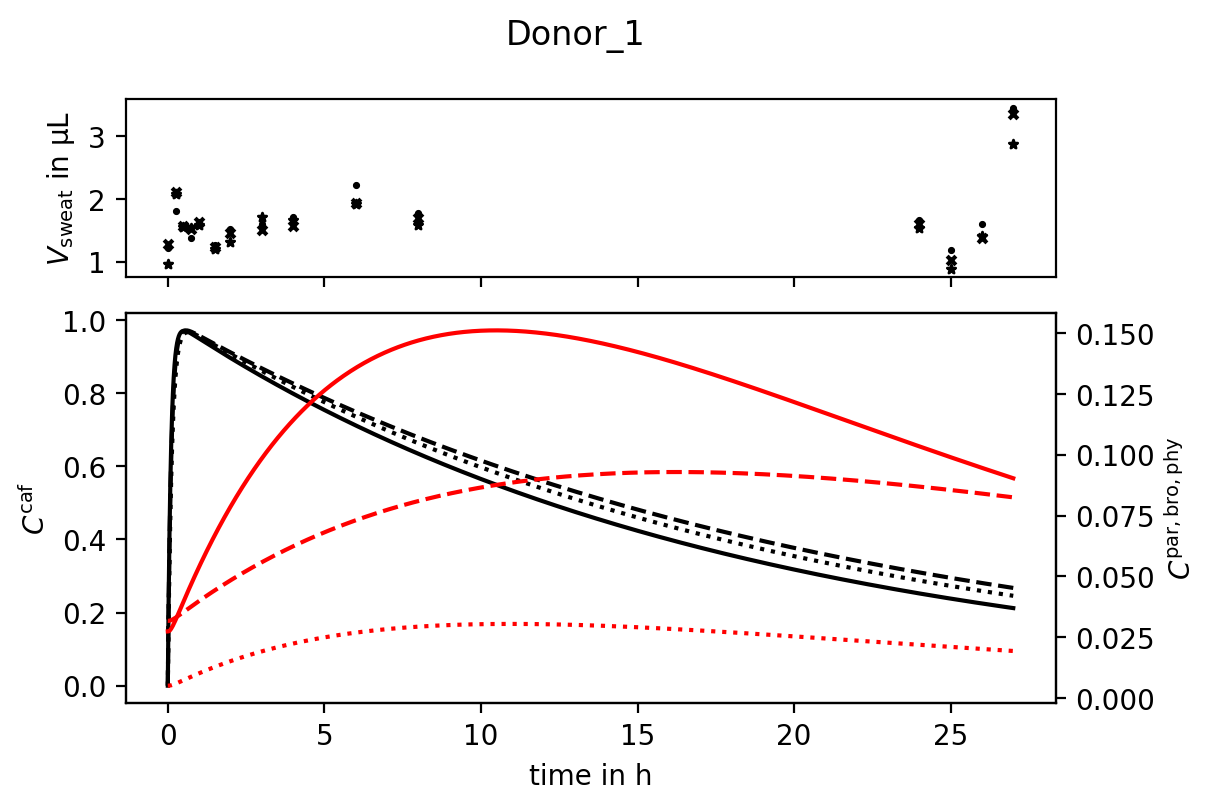

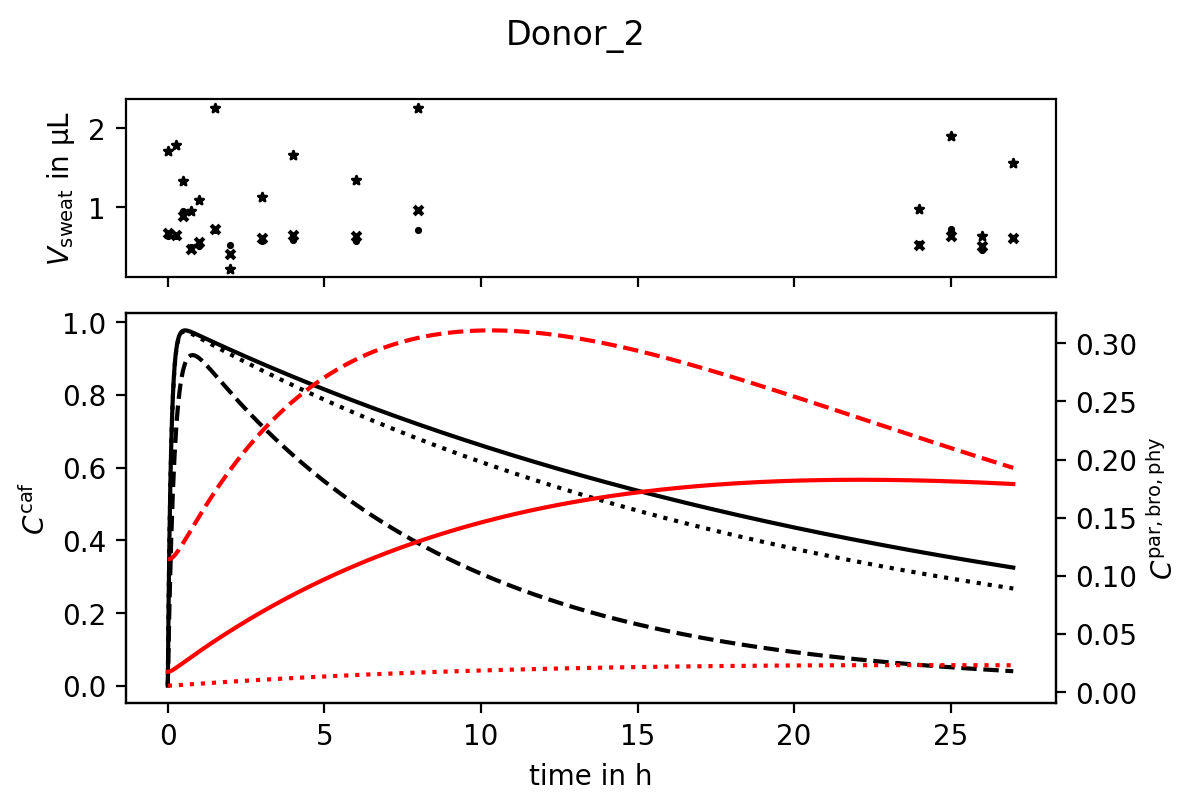

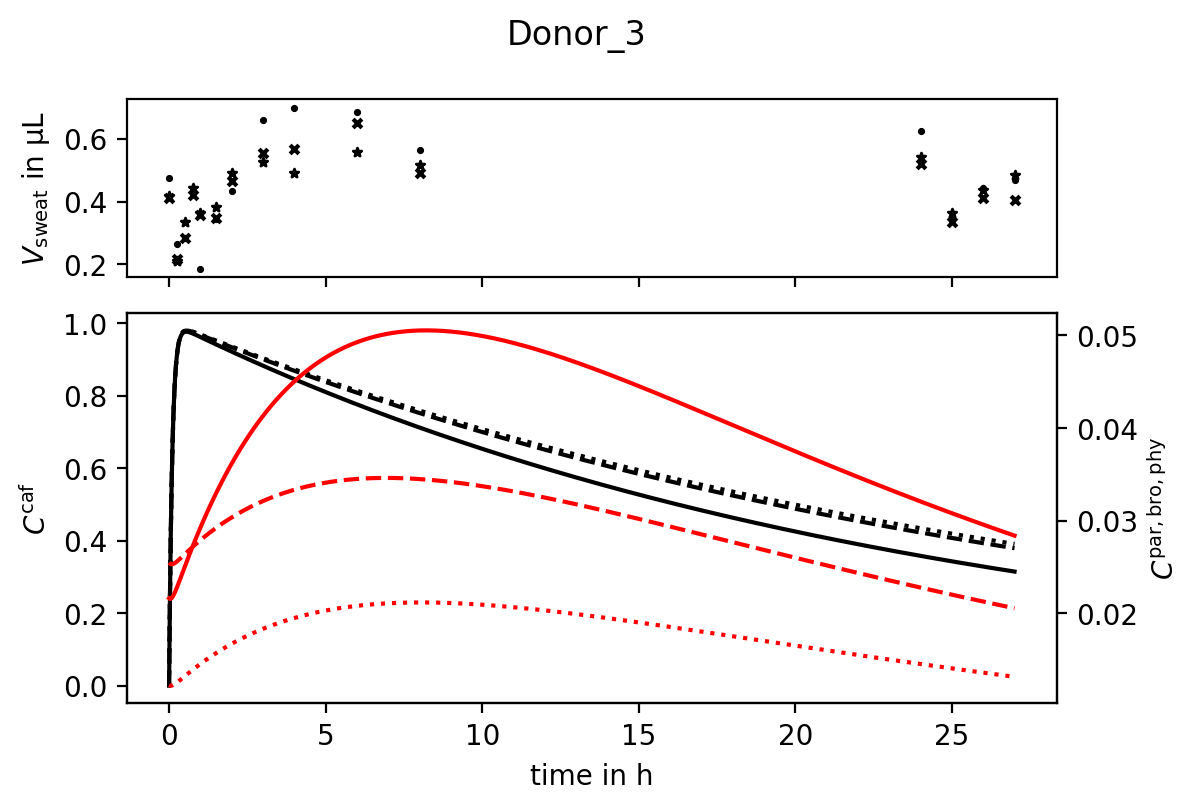

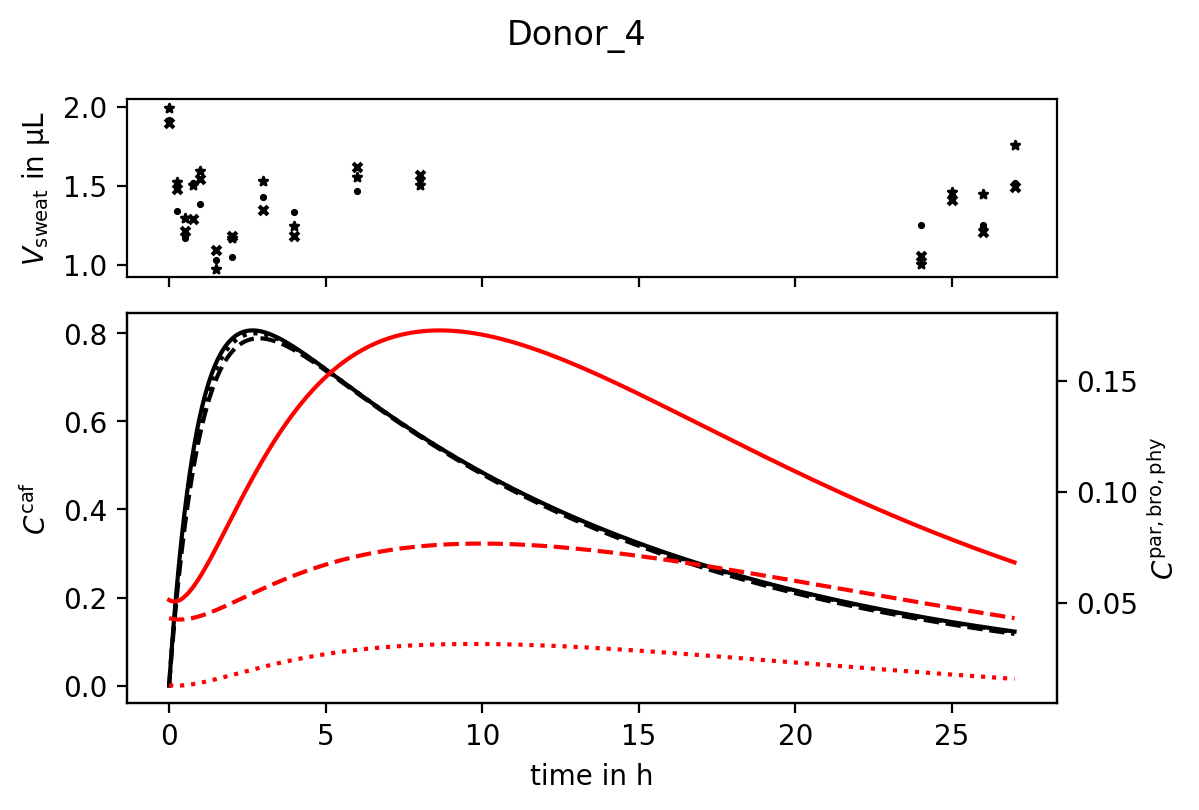

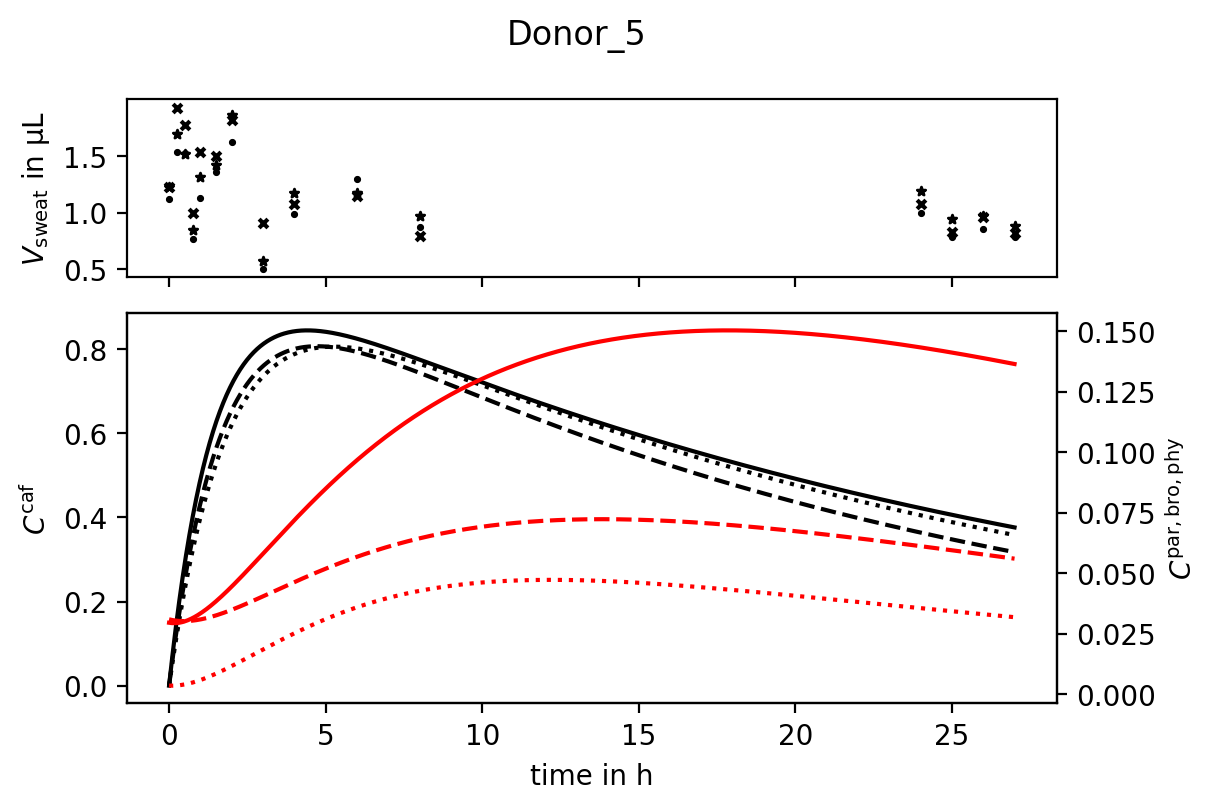

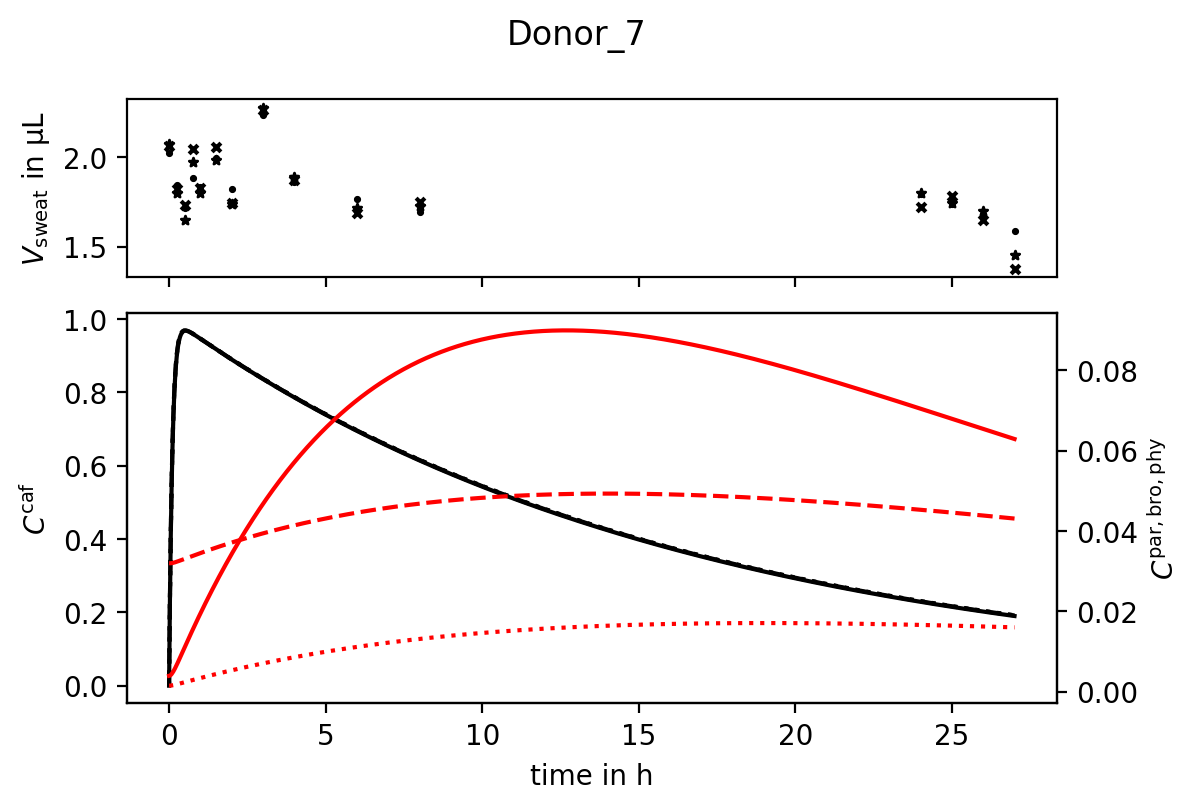

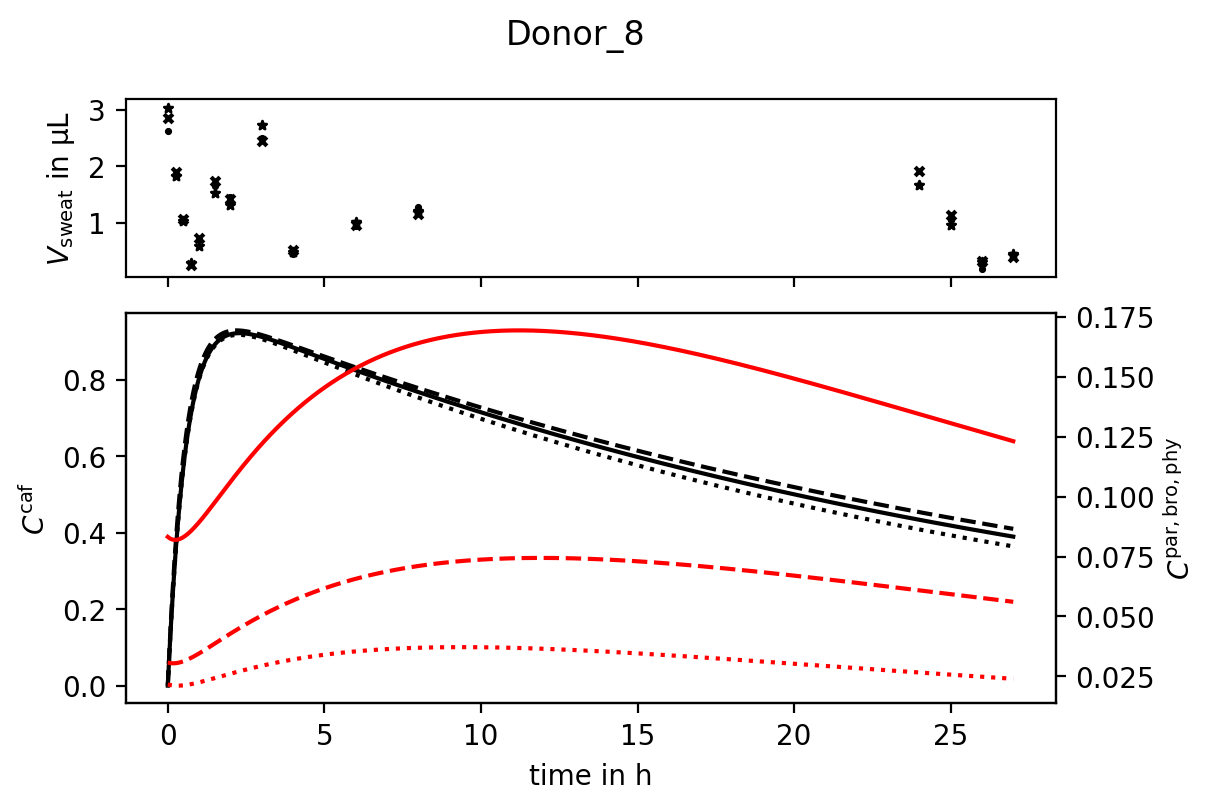

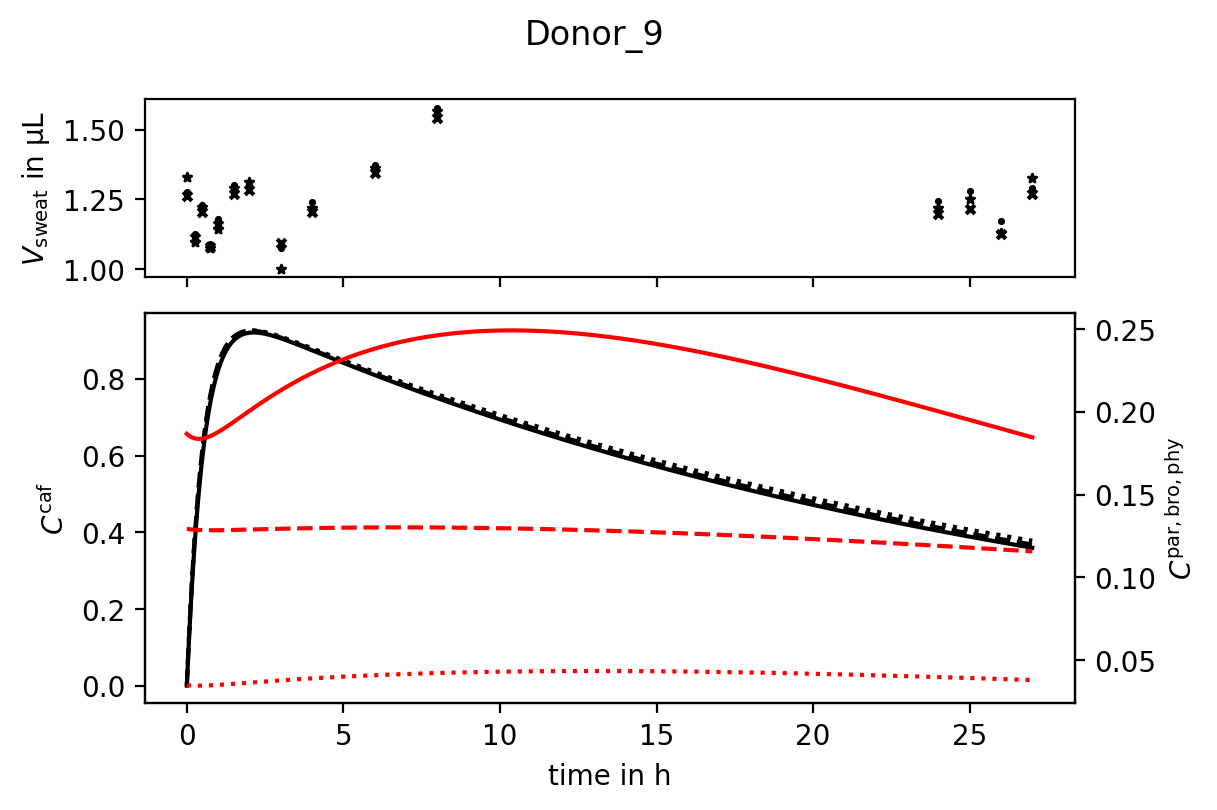

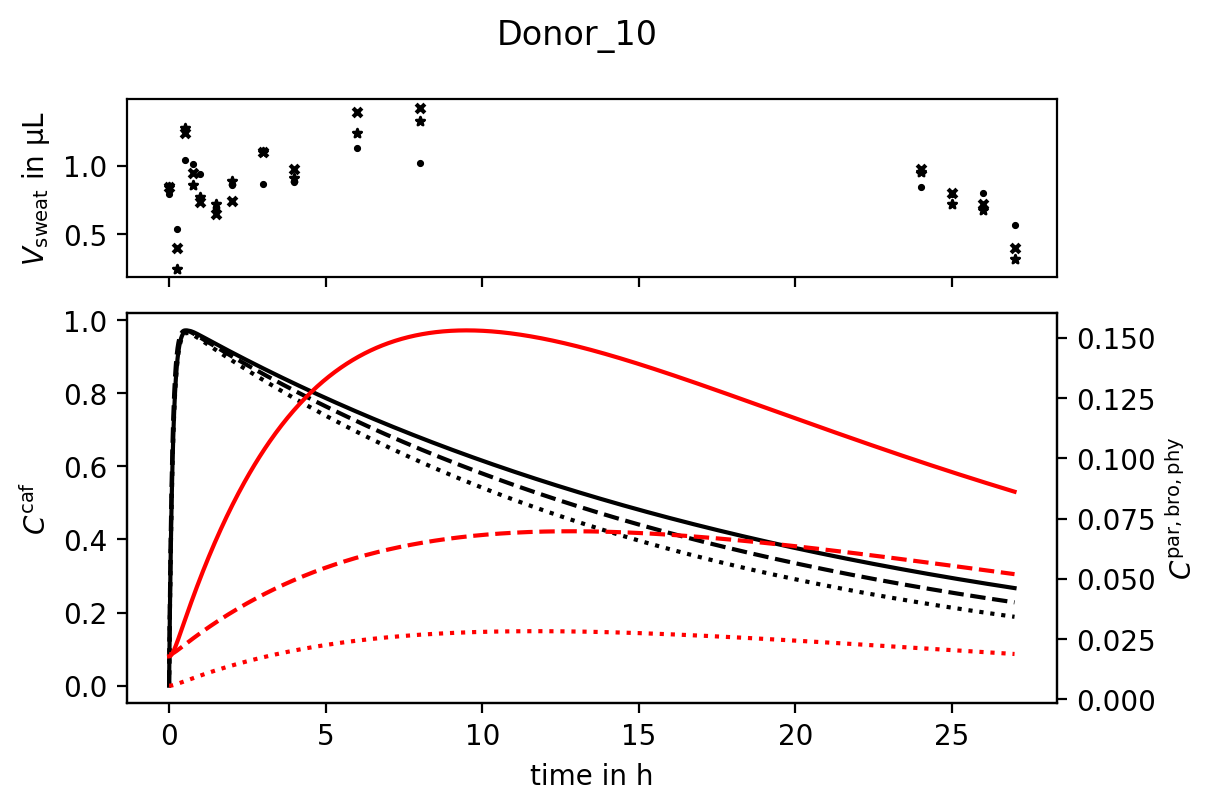

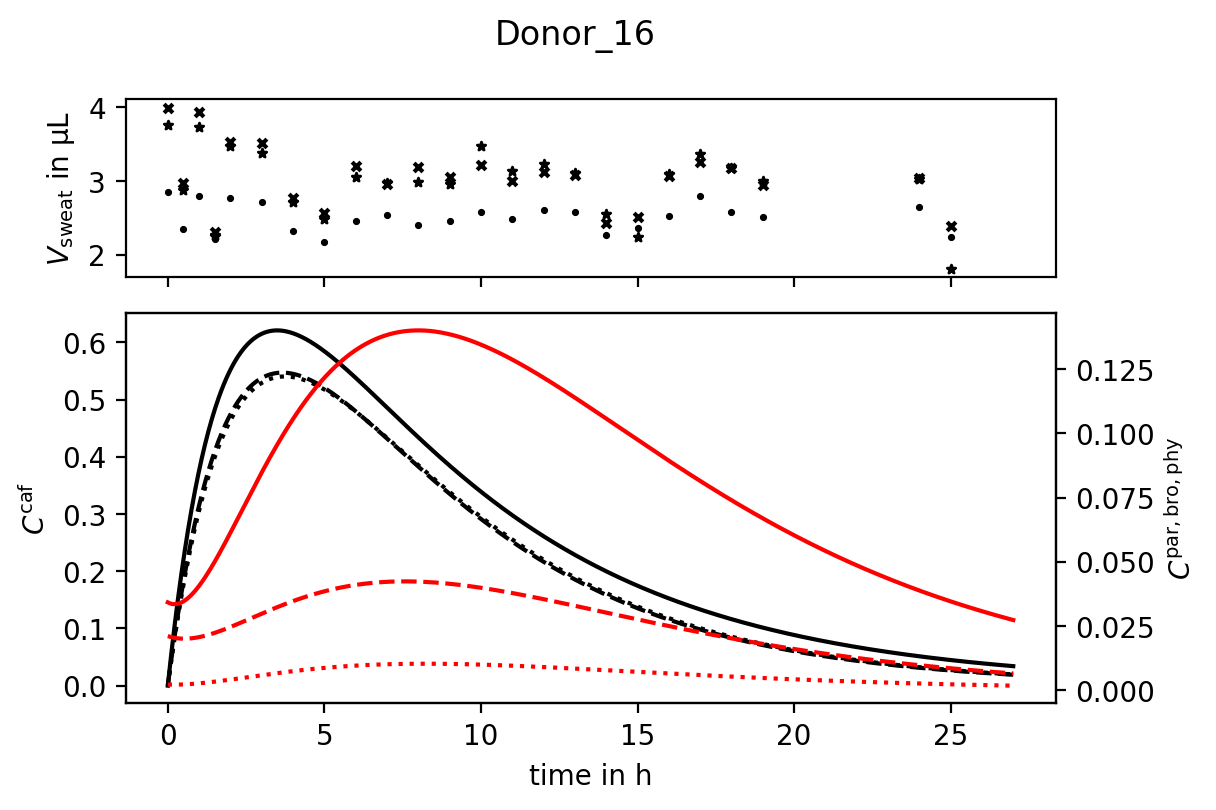

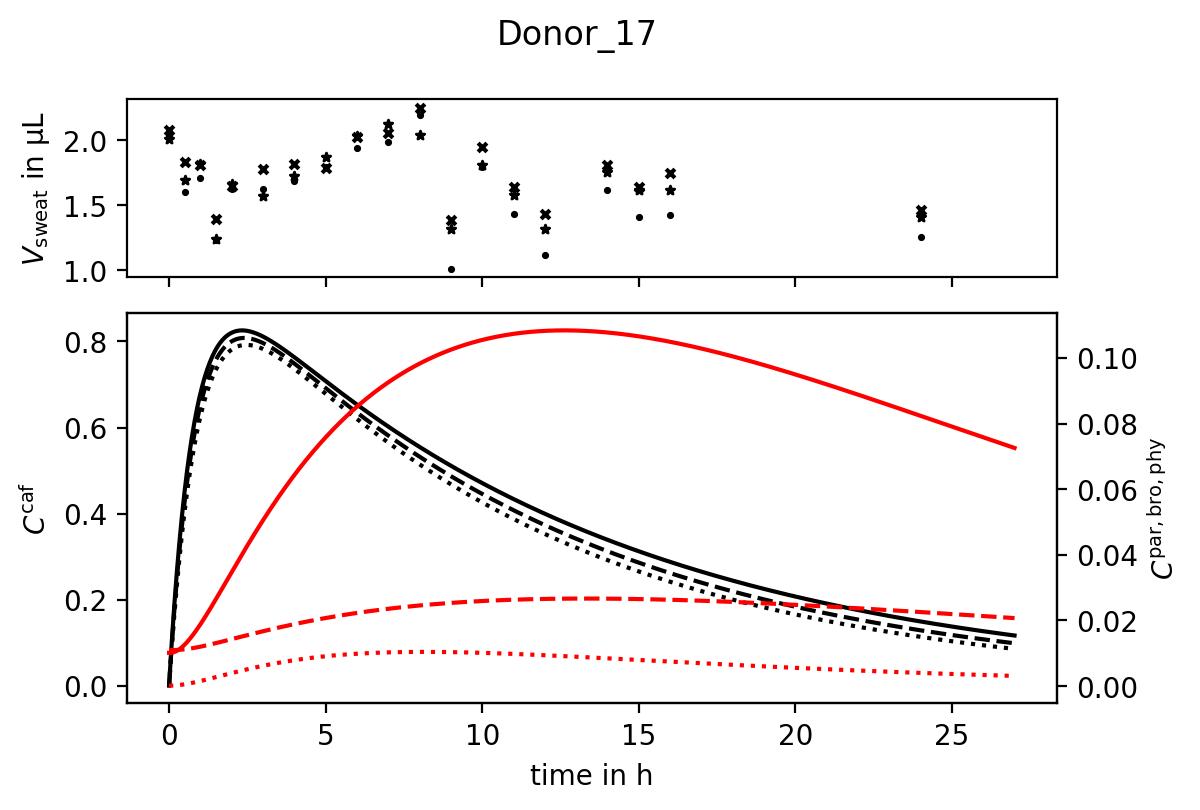

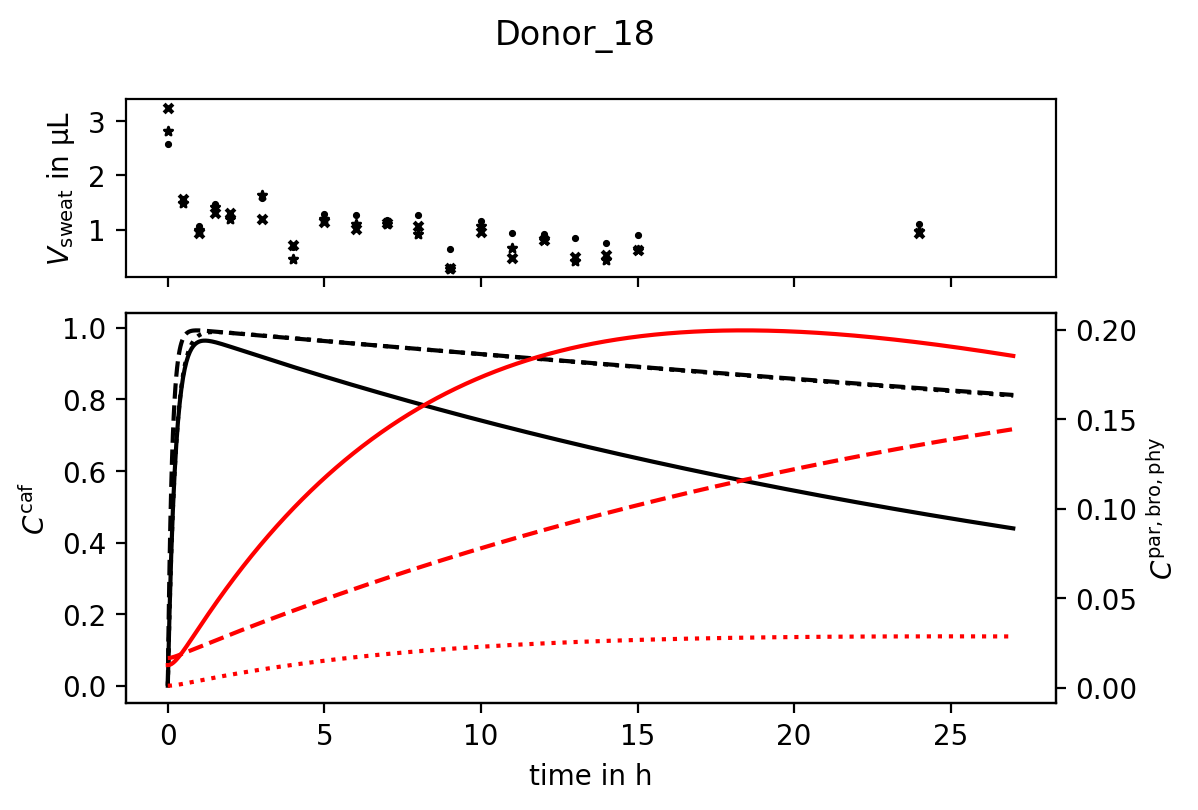

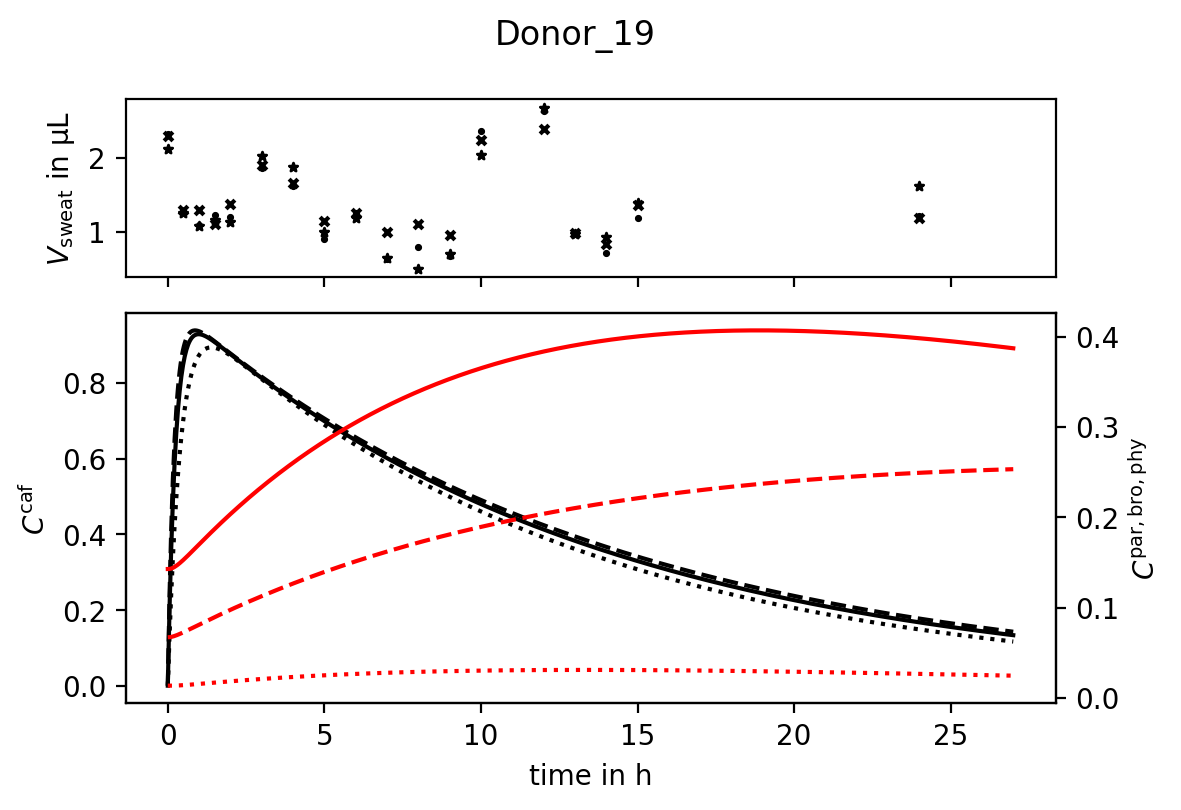

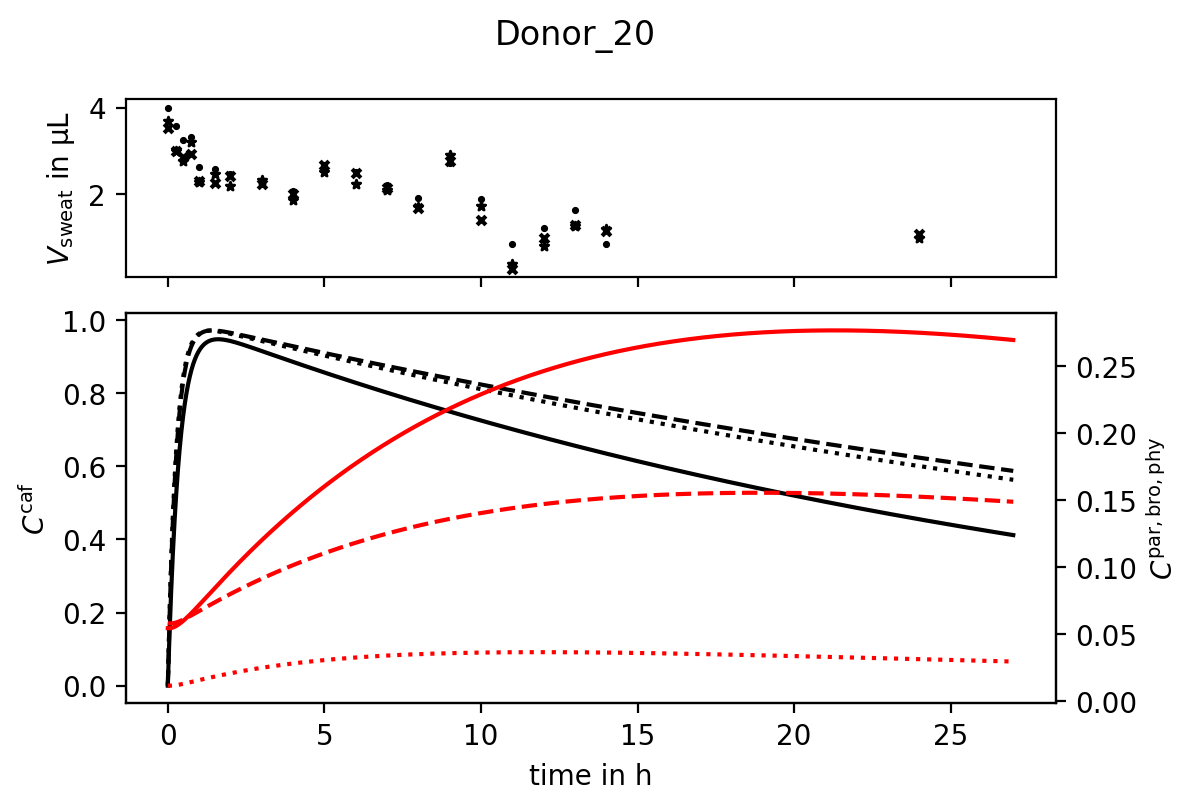

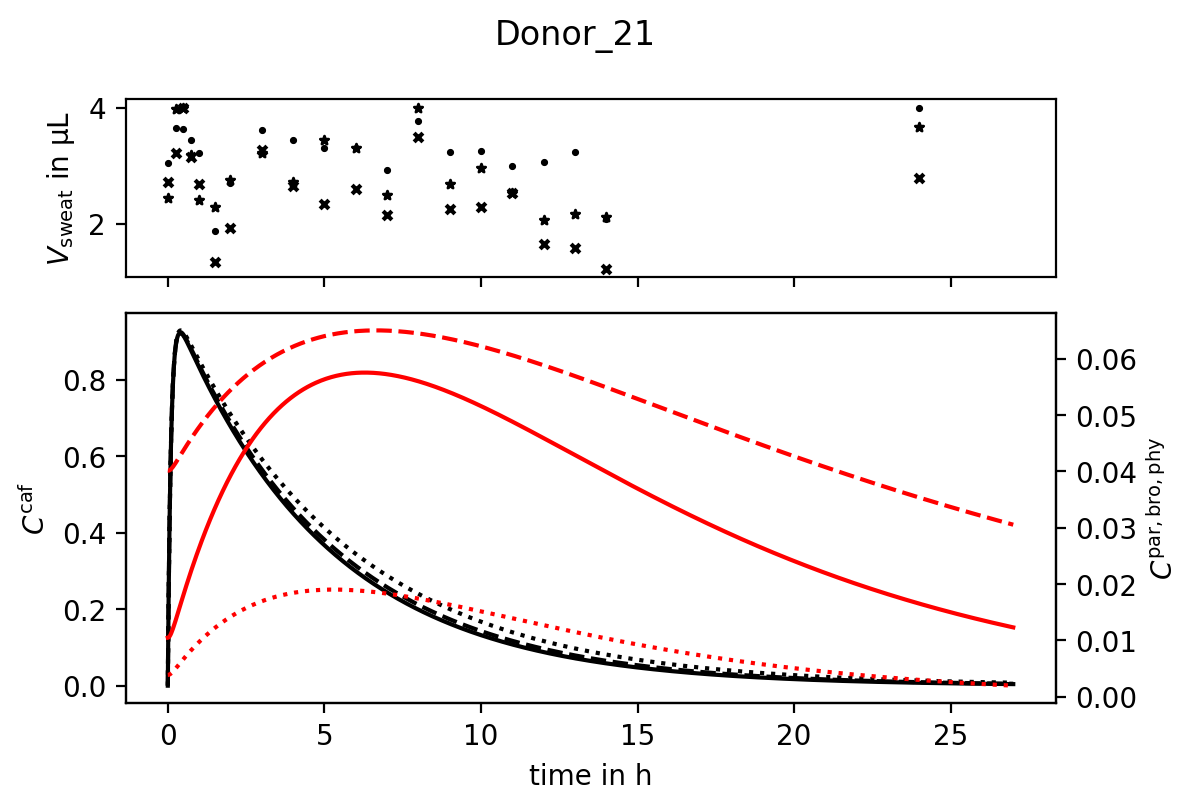

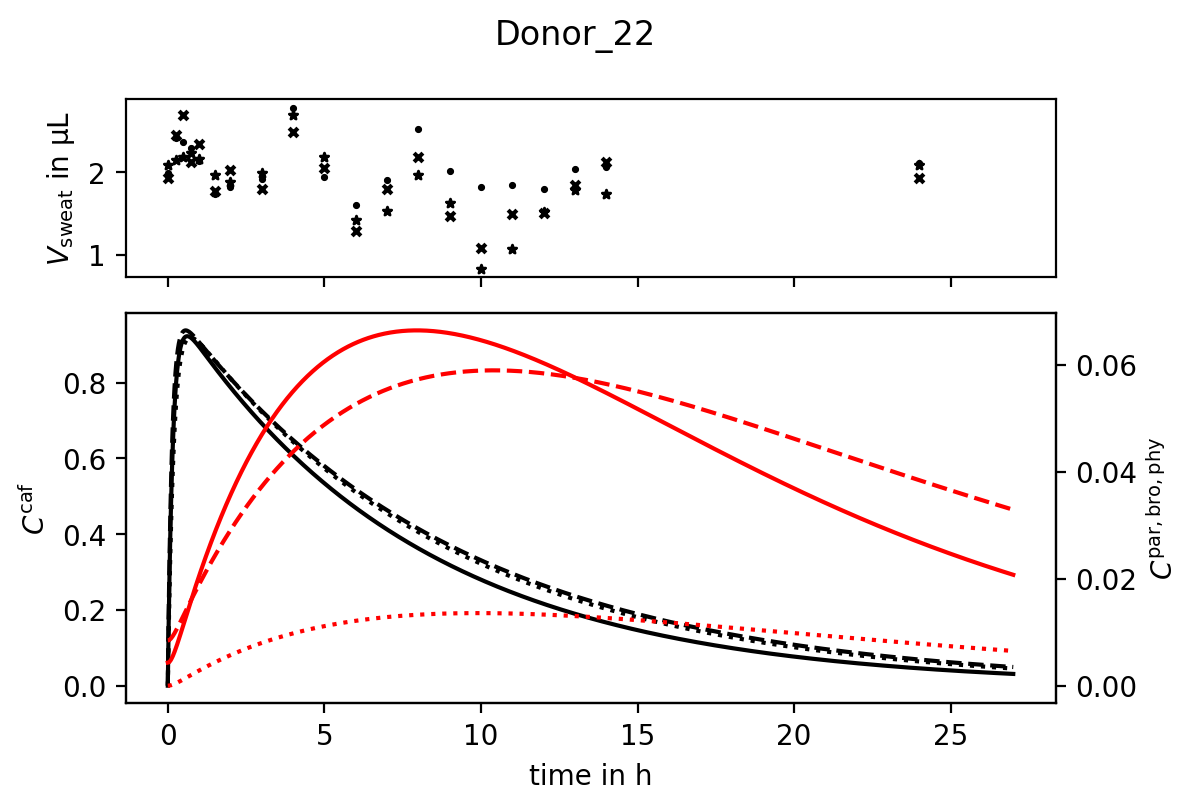

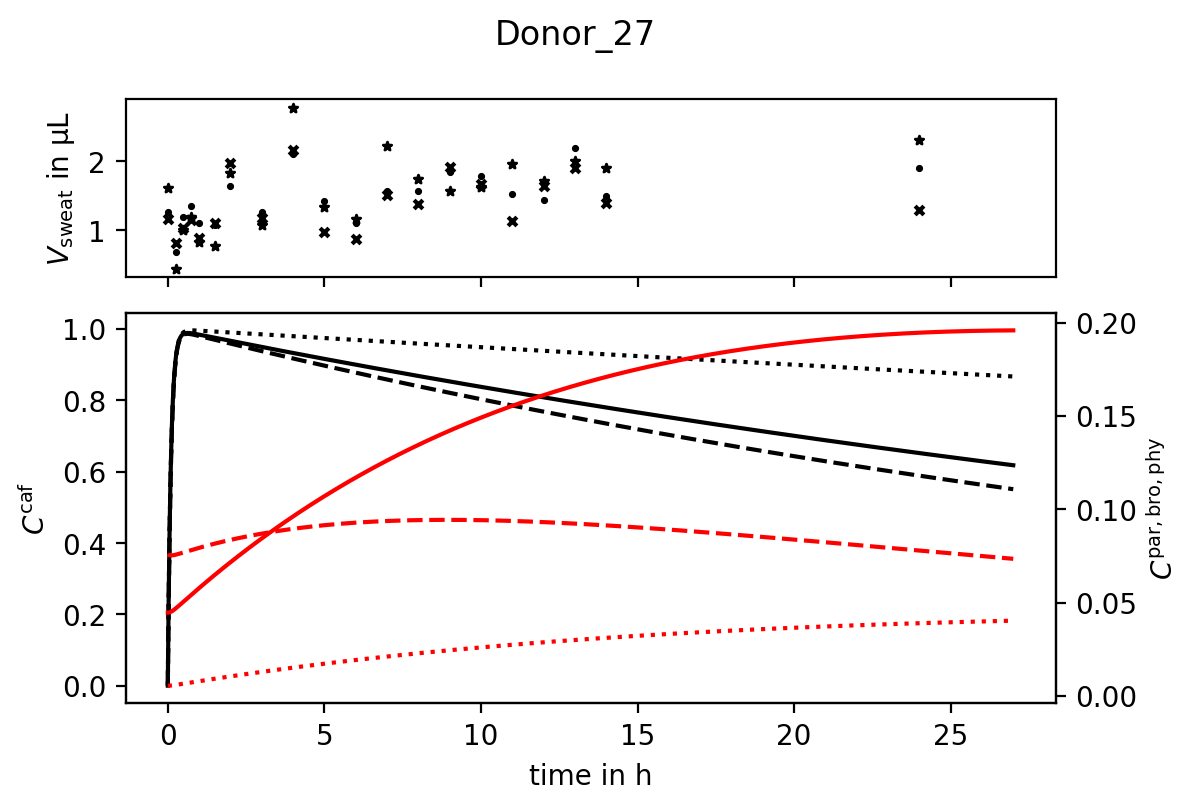

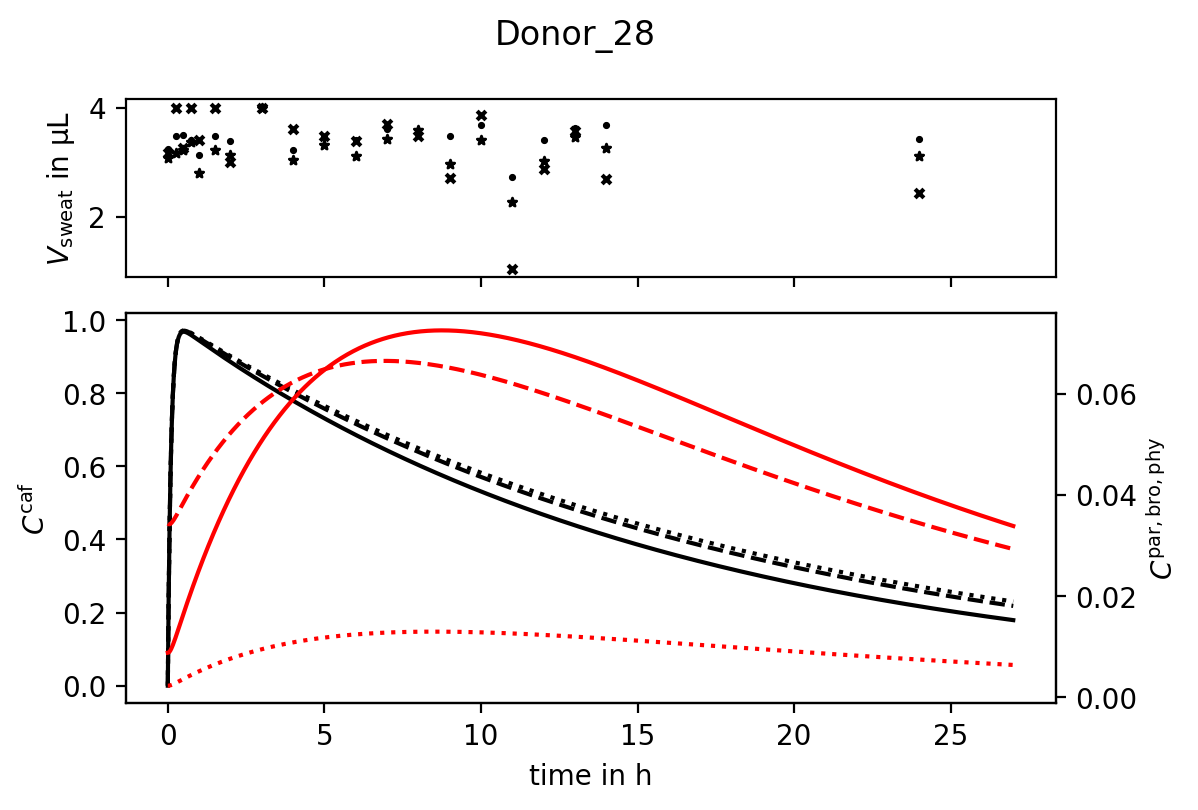

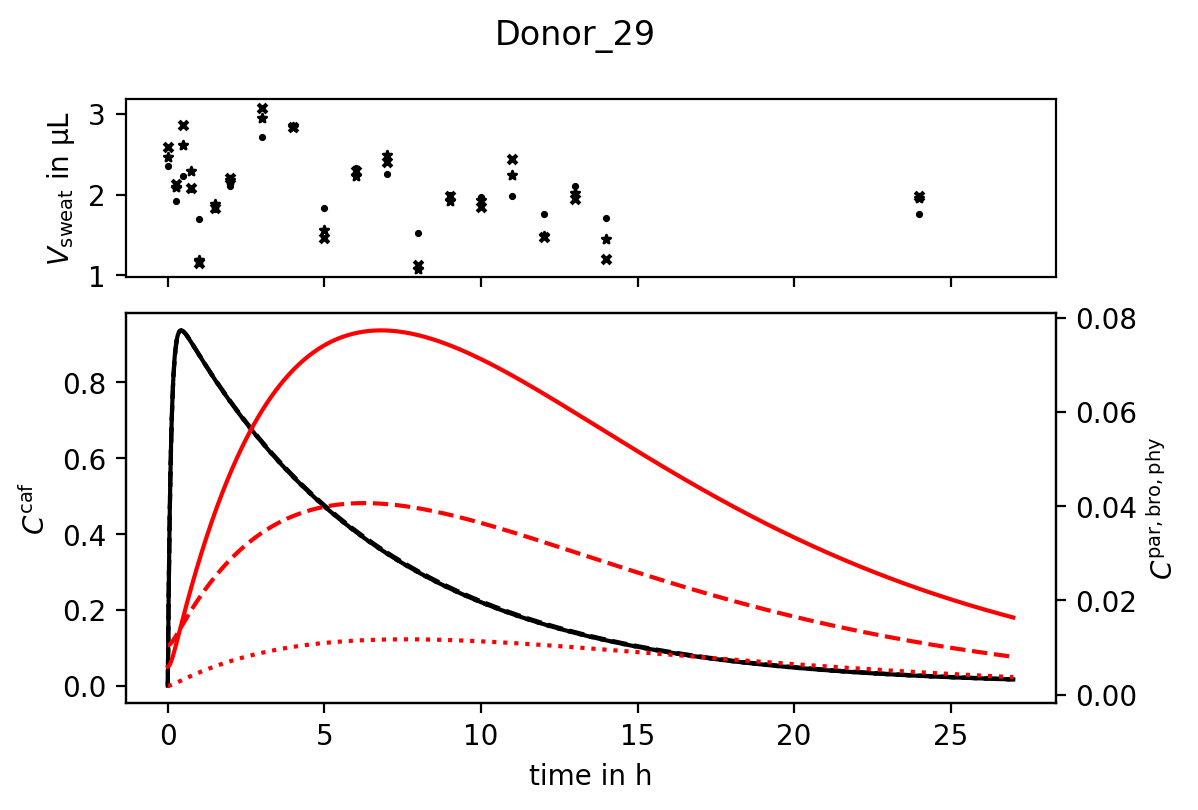

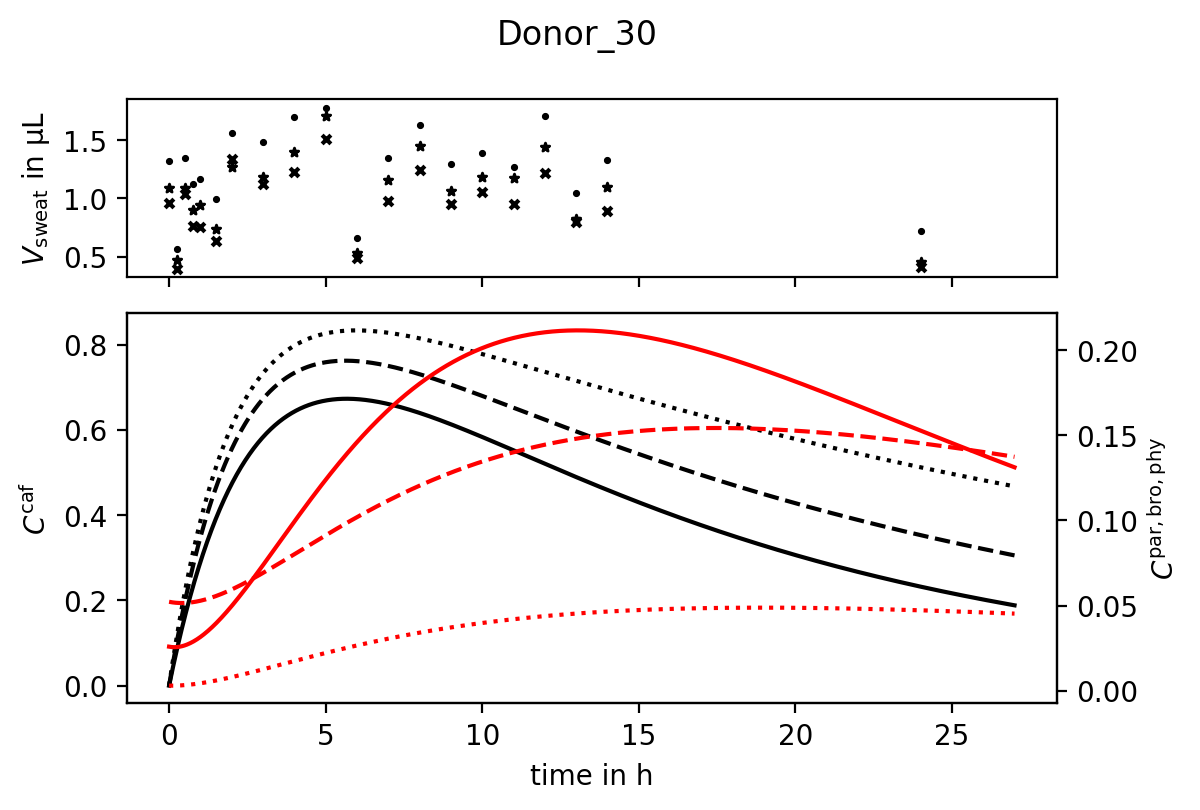

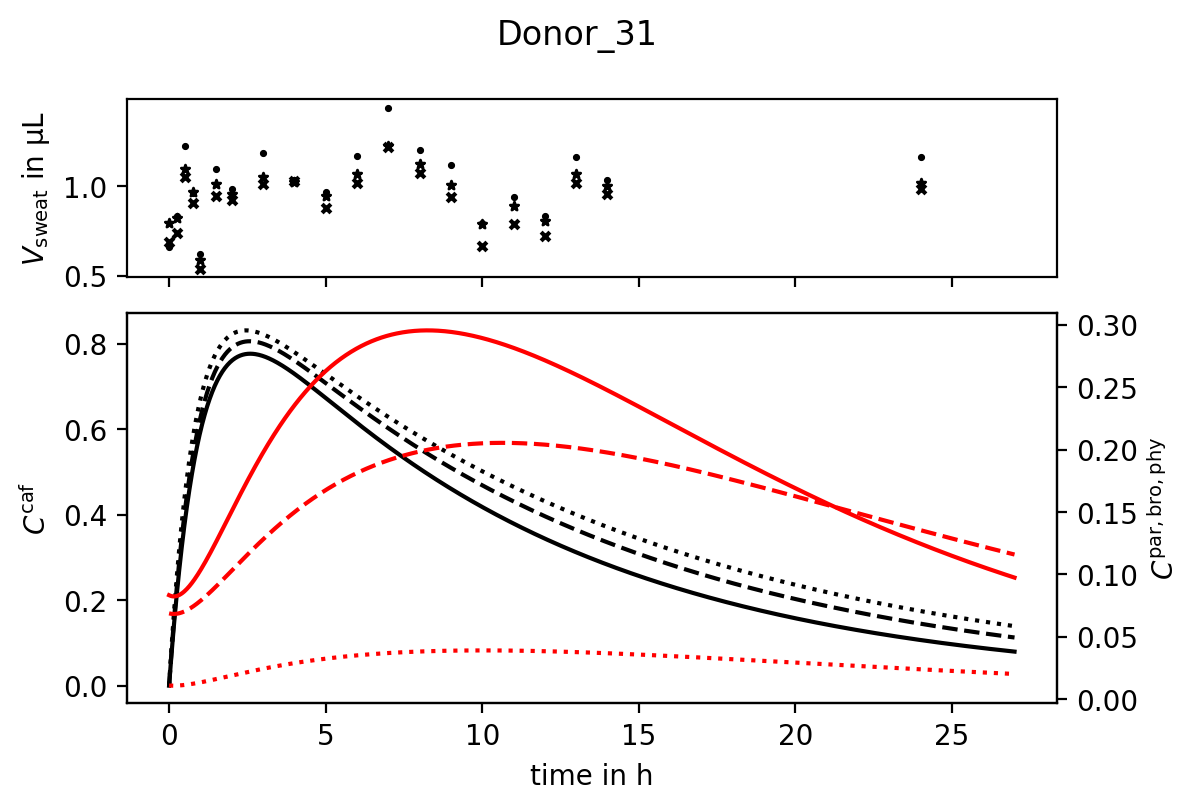

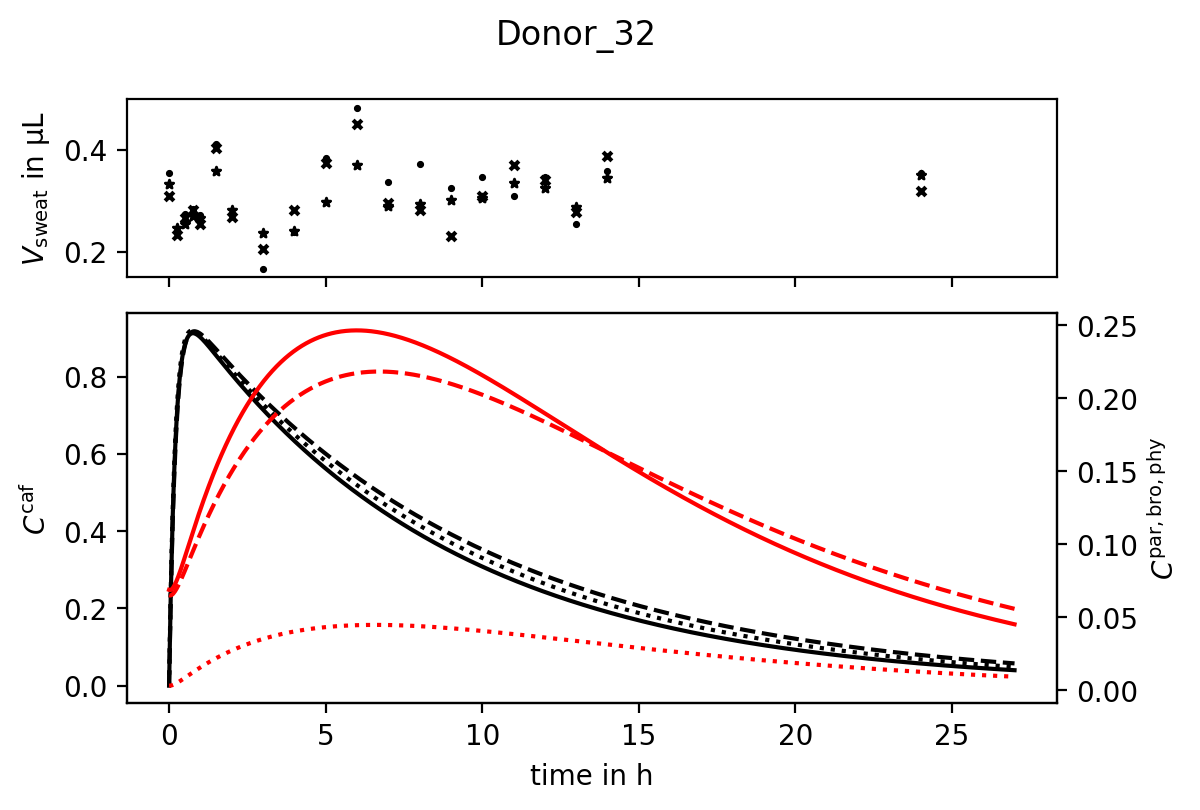

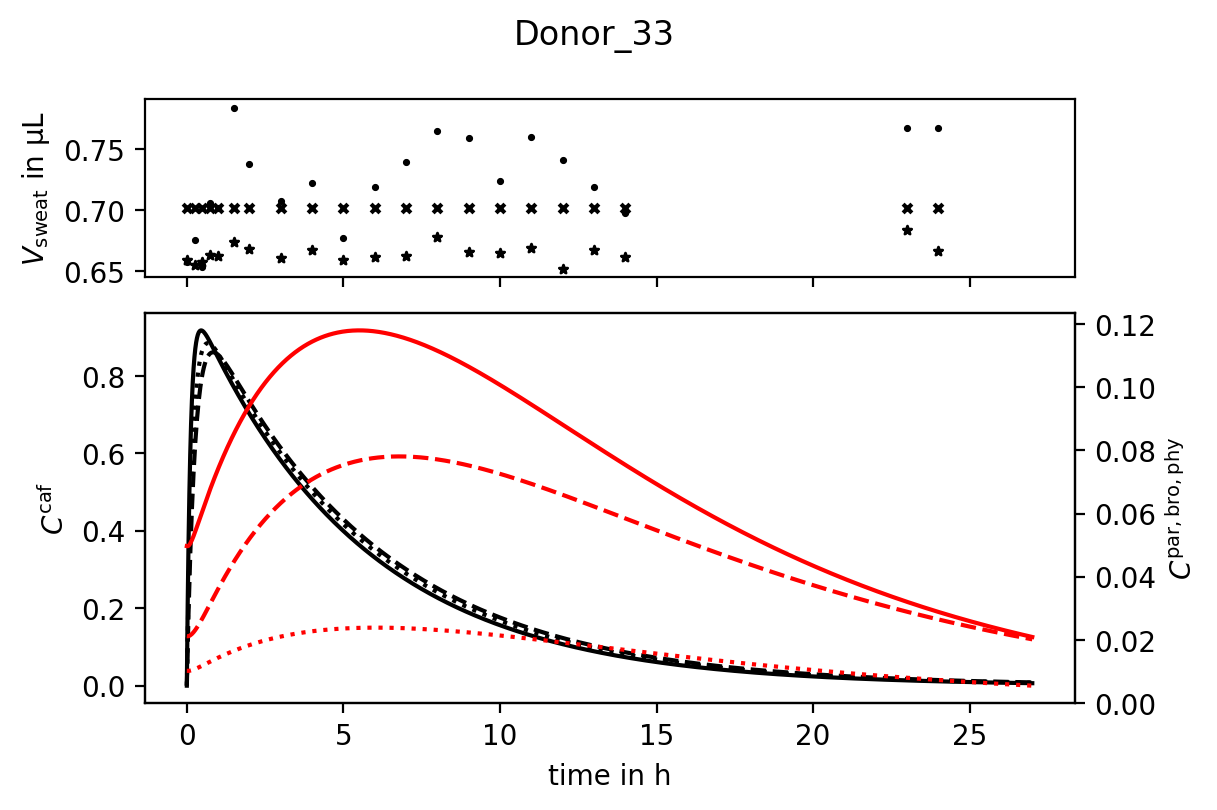

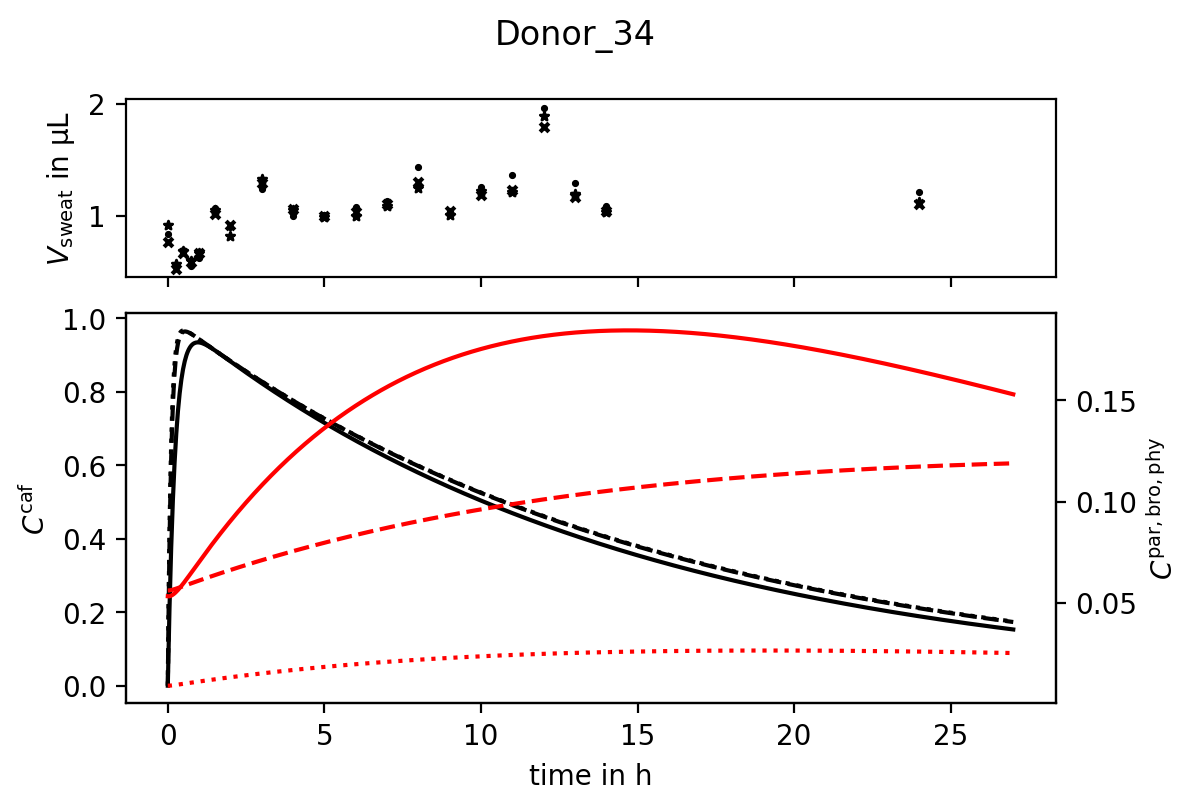

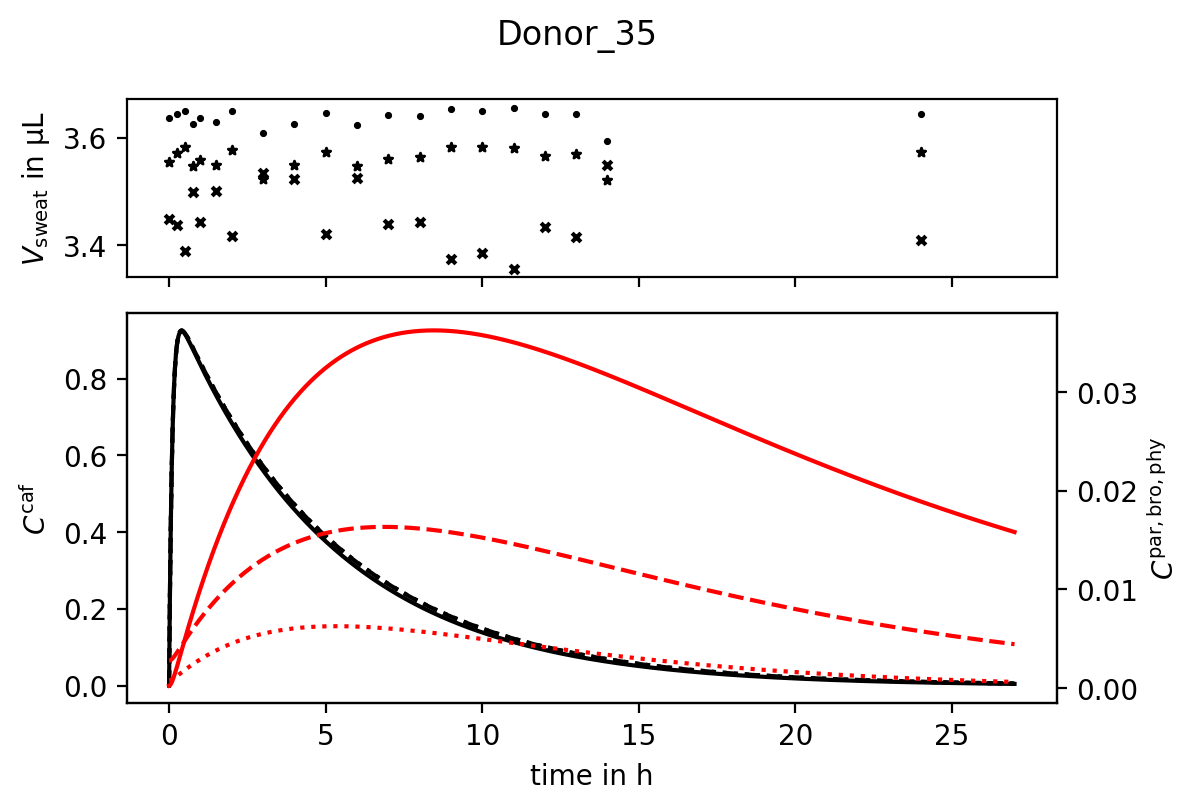

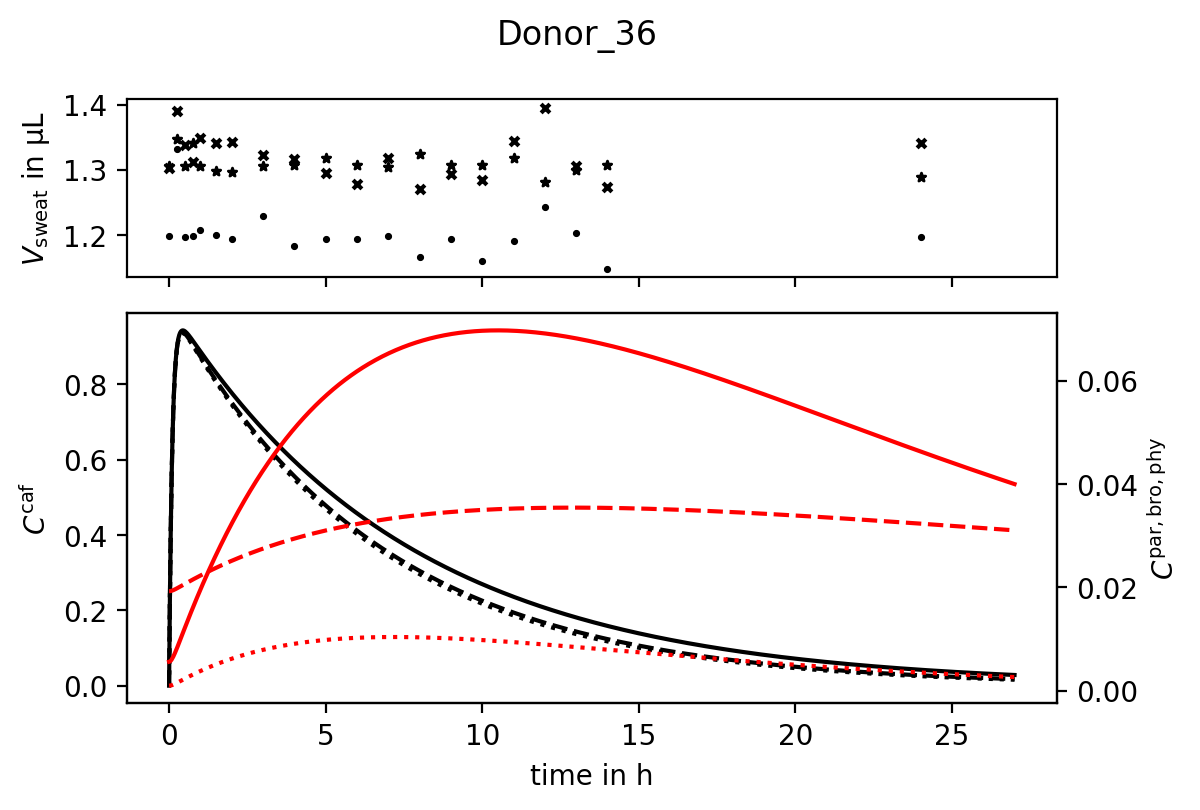

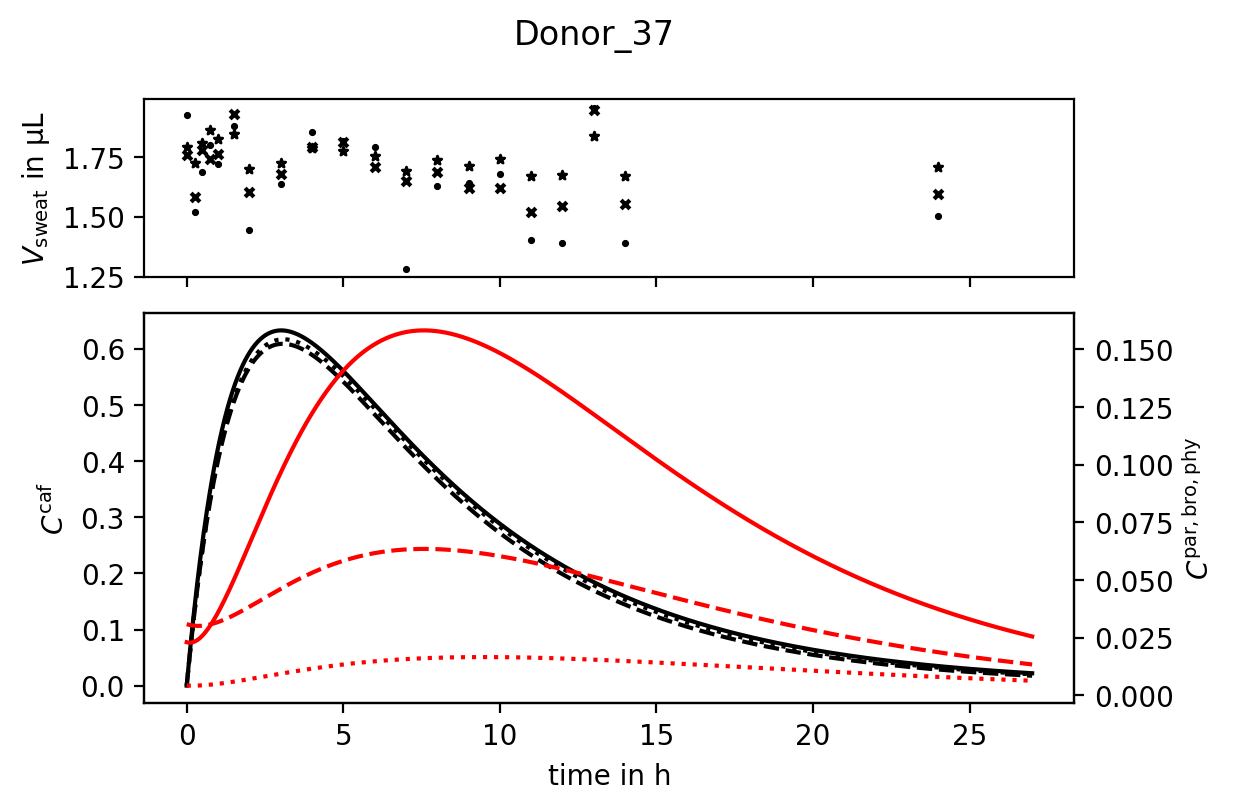

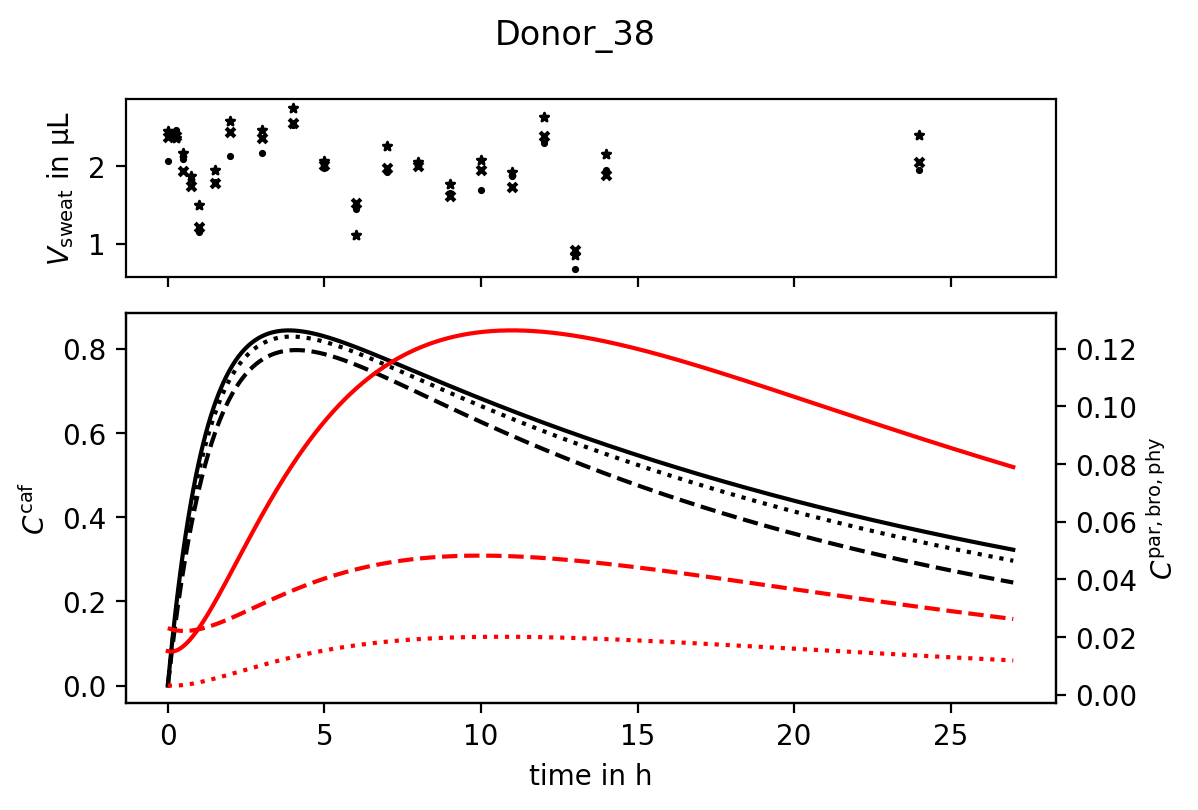

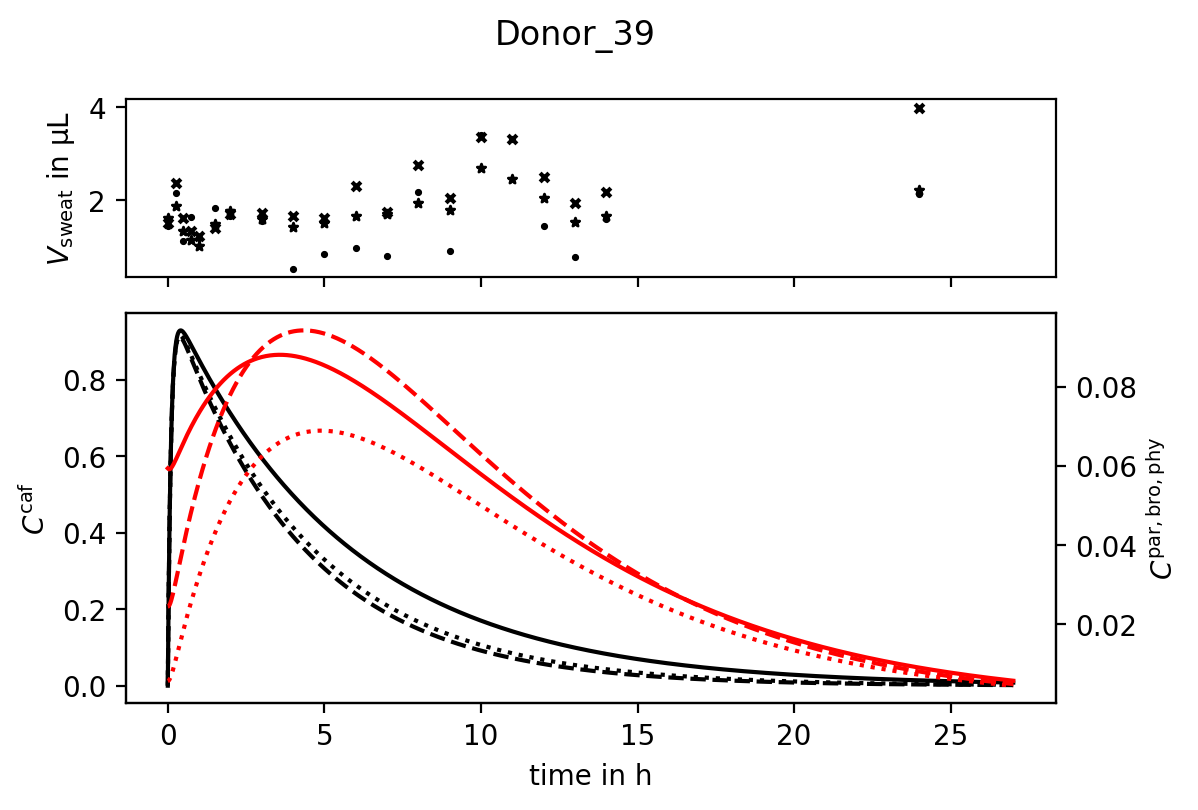

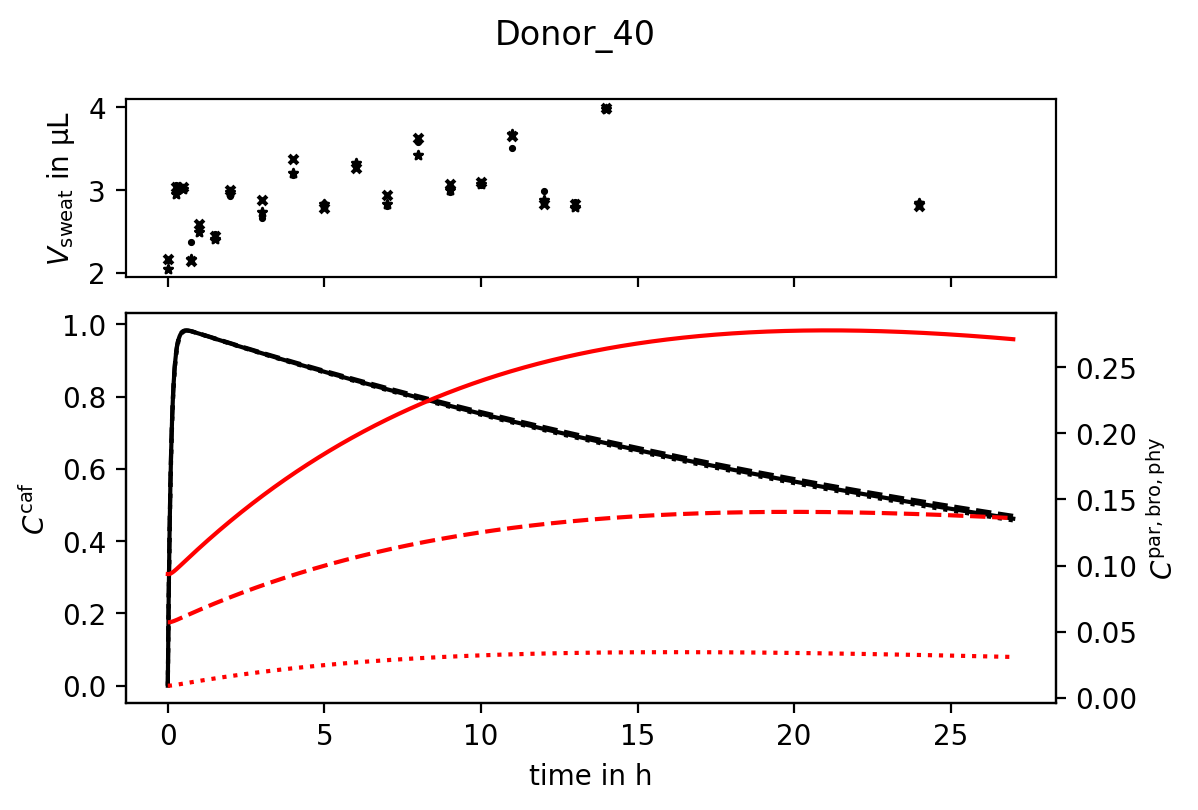

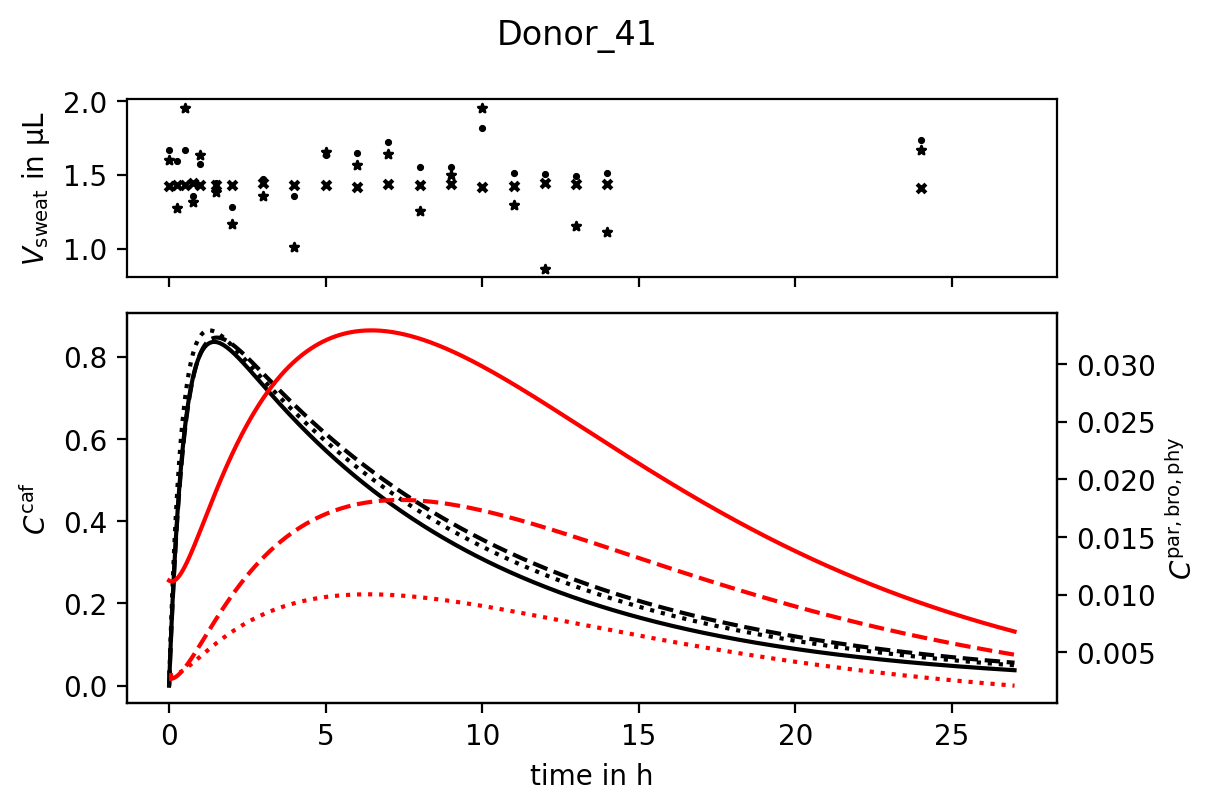

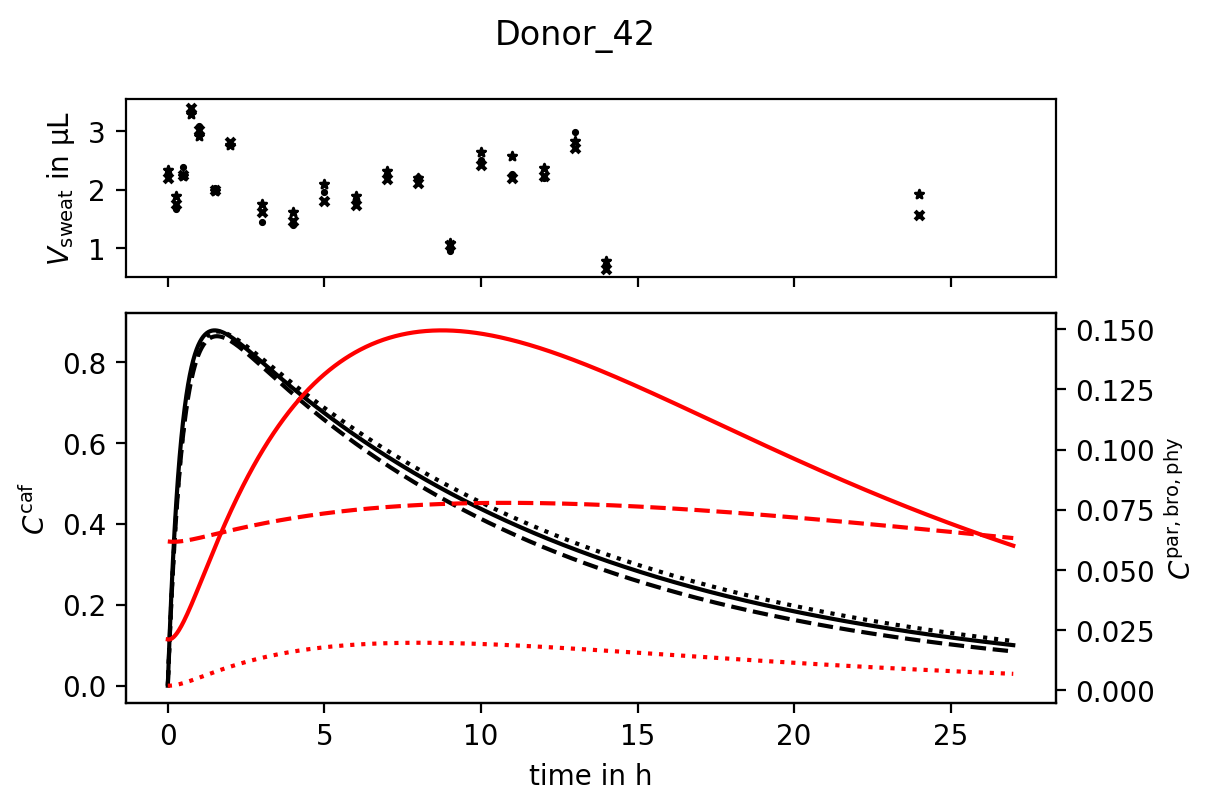

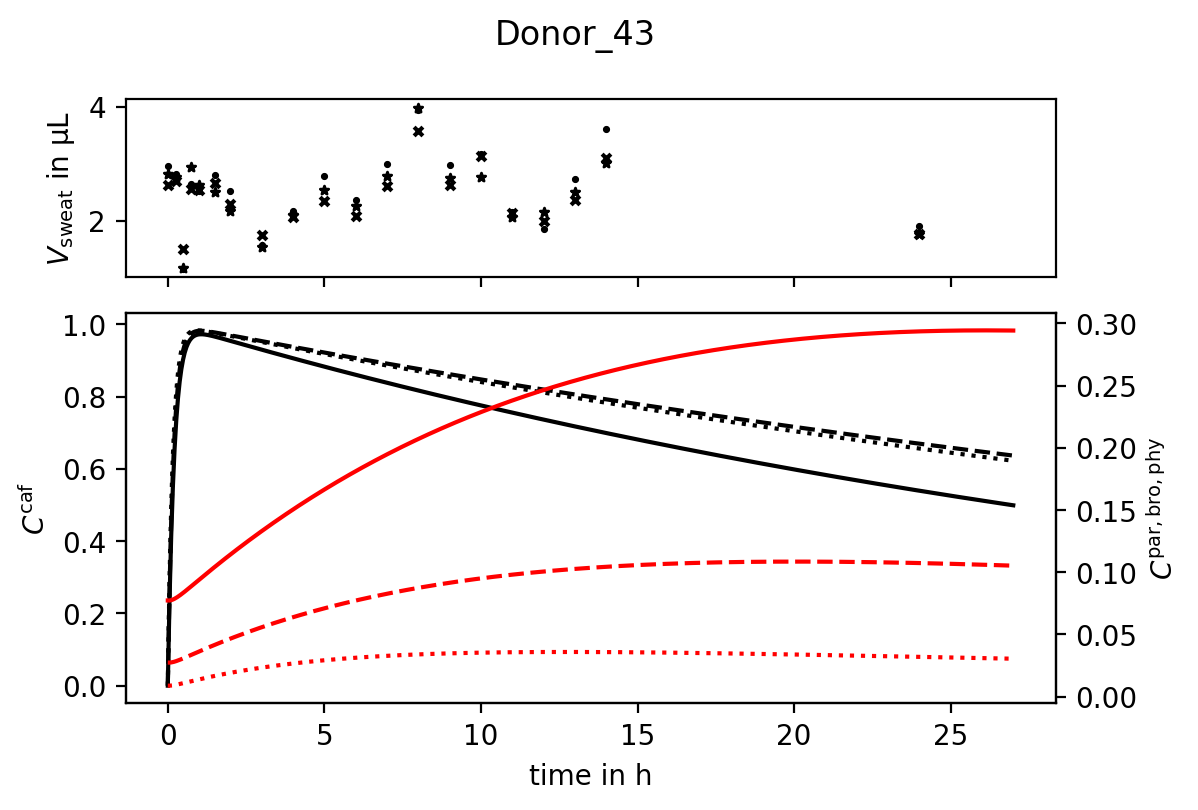

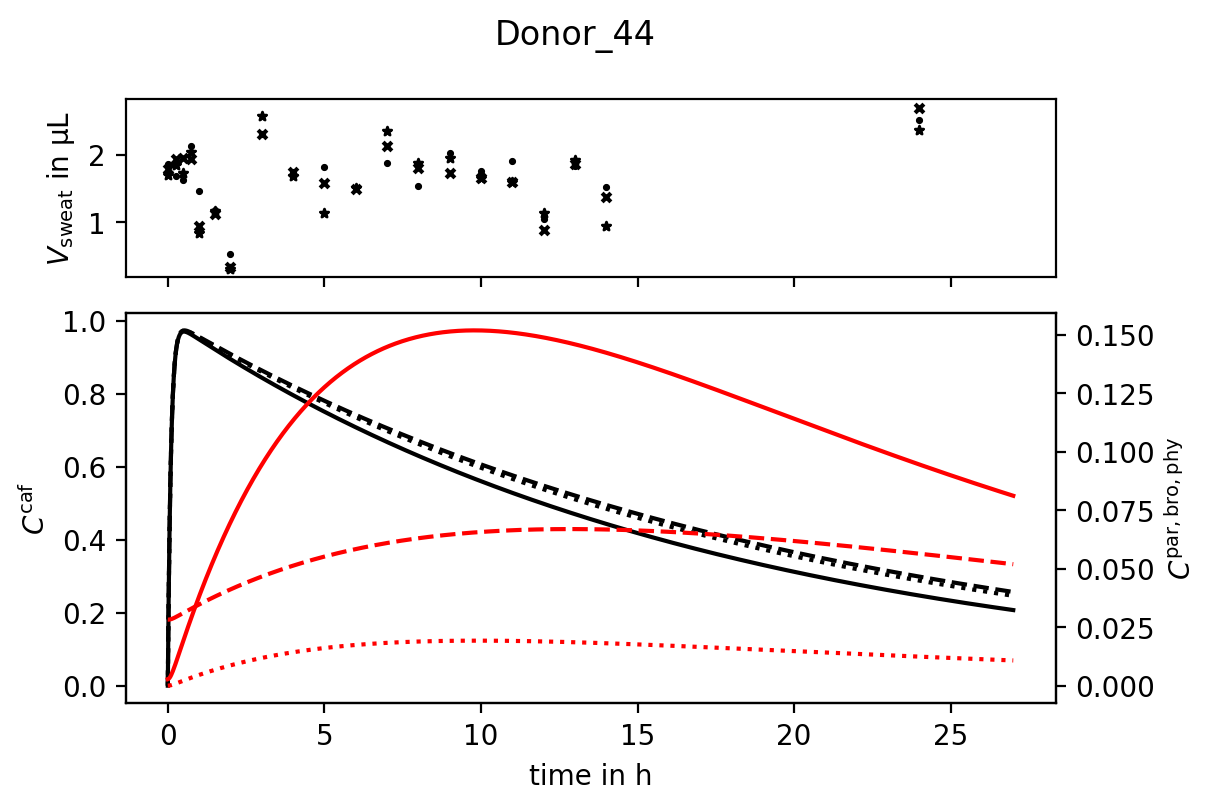

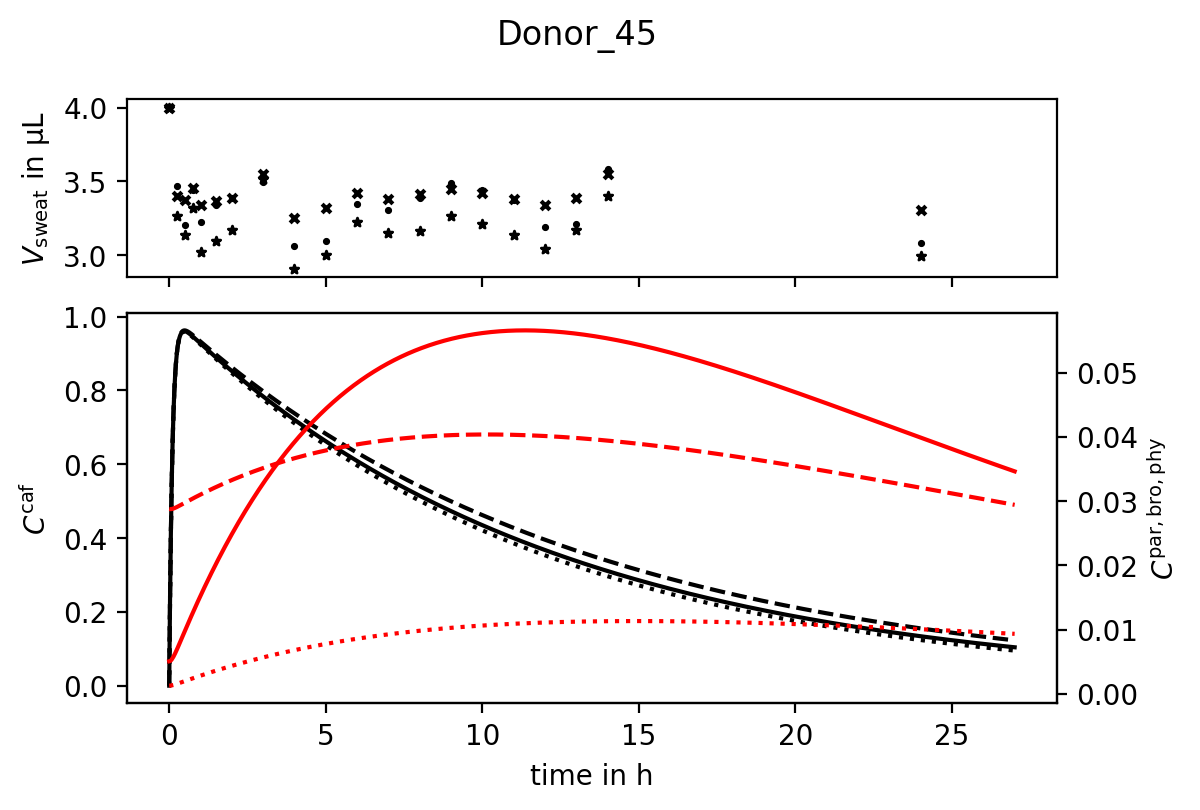

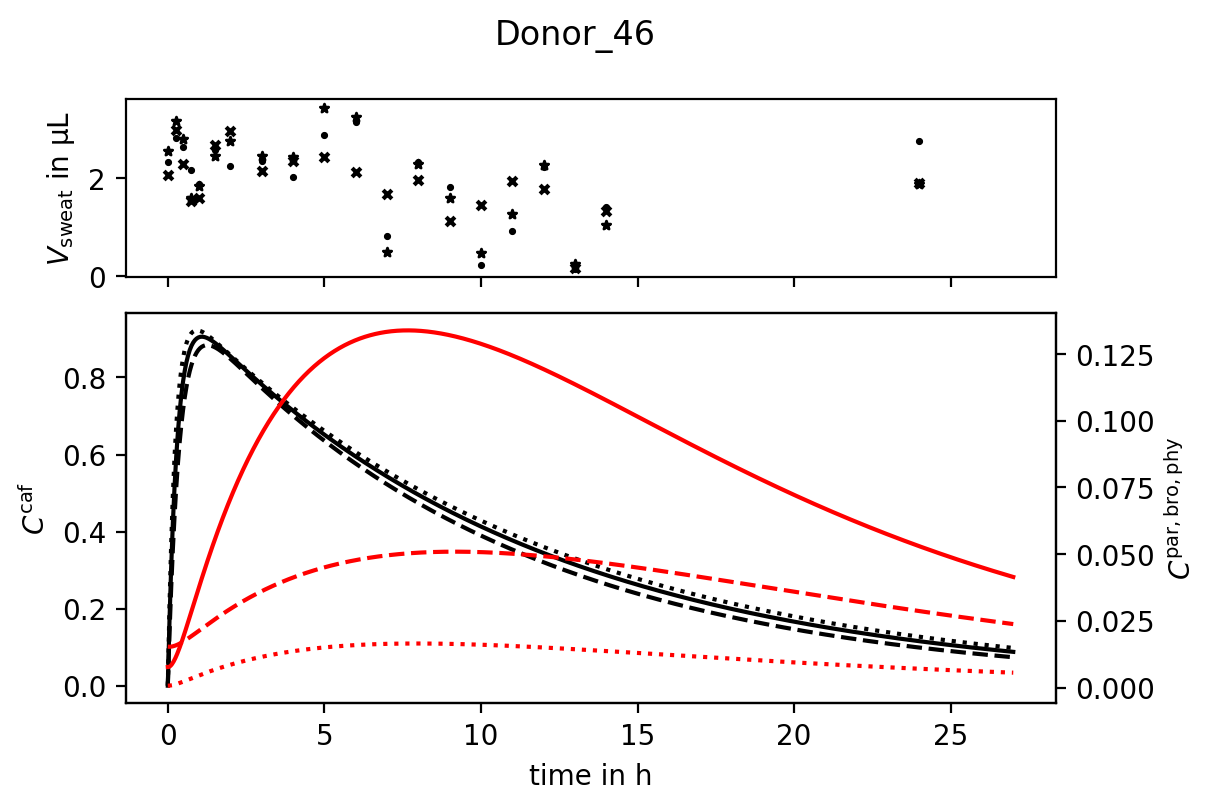

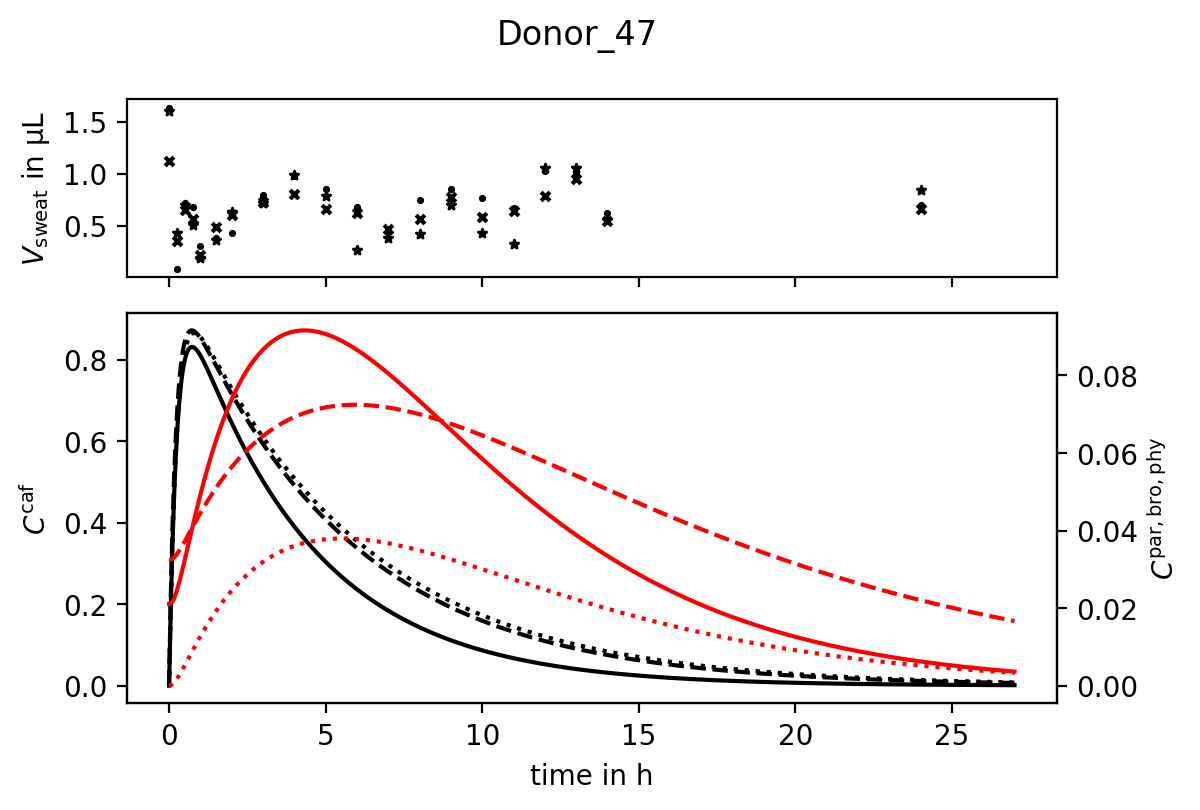

In [8]:
for donor in donors:
    plot_time_series(donor)
#     break